# Model Designation

This use case belongs to the class of generative probabilistic classical machine learning tasks. Let me elaborate this.
- Generative means that there the objective of the model is to lear the multivariate distribution which is generating the data, and on the basis of this conclusion, produce new samples of data originating from the same multivarite distribution. Therefore, generated data is not a copy of original data, but a product of the statistical interpretaion of the same underlying distribution.
- Probabilistic means that the model is utilizing probabilistic methodology Dirichlet process to determine the effective number of clusters which will be derived from the data.
- Classical means that the machine leraning task is not utilazing ANN technology for learning.

# Objective of Learning Task

The objective is to develop a model which can learn the underlying multivariate distribution from which the data is being generated. 
On the basis of absorbing this knowledge, the trained model will ultimately be able to generate new samples which are a product of the statistical interpretation of the same underlying process which led to the creation of the data in the first place.
For the purposes of this demonstration a collection of images will assume the role of original data. An attempt to generate new data, will be made with Bayesian variation of Gaussian Mixture Model.

# Technology Stack

Python has been selected for the purposes of model development. Virtualenv package is utilized for generation of specific environments. Scikit-learn is the package for ML models and aditional functinalities, while the low level API for numerical computation is Intel Math Kernel Library (MKL). Data manitpulation is mostly done in numpy because there is there is no pronunced need to use labeled feature and target vectors. Therefore, it is necesary to use these techonogies in order to obtain reproducibility as well as sucessful execution of modeling tasks.

# Methodology of Model Training and Testing

Develipment of generative models is similar to the development of unsupervised ML models, in that sense that there is no formal proces of model testing, ie. it is not possible to evaluate model performance on the basis of comparison between reference and prediction.
The quality of model is determined on its ability to generate new samples, and therefore a model which is trained to succed in this task is considered as sucessful.
The absence of formal testing procedure, has implications on the training process as well. Therefore, there is no splitting of the data to training and testing set, but rather the entire available data is used for model training. The more sample there is for model to absorb, the more skilfull the model will be in generating new samples.

# Model Development

Firstly, its necessary to import required packages.

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from math import floor, ceil
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
from joblib import dump, load
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
import h5py

Now, we will define a fucntion to get names of all files within desired folder.

In [3]:
def get_all_files_within_folder(path):
    """
    Return a list wh. all files within a folder specified in path.
    """
    return [
        file for file in os.listdir(path) if os.path.isfile(
            os.path.join(path, file)
        )
    ]

We also need a function to get all images within a desired folder.

In [4]:
def get_images(path):
    """
    Return data frame with images loaded from a folder designated
    in path. Resize, convert to gray-scale, and flatten the images.
    """
    # Get names of image files.
    image_file_names = get_all_files_within_folder(path=path)
    # Set working directory.
    os.chdir(path)
    # Iterate over files and load images.
    for image in enumerate(image_file_names):
        print('Getting data for image: %s' % (str(image[0])))
        # Get image from file.
        image_array = Image.open(image[1])
        # Resize image
        resized_image = resize_image_according_to_width(
            inn=image_array,
            proportion=.16
        )
        # Convert to gray-scale.
        image_gray = resized_image.convert('L')
        # Flatten.
        flattened_image = np.array(image_gray).reshape(-1)
        # On first pass place into a matrix.
        if image[0] == 0:
            out = np.matrix(flattened_image)
        # On all other passes concatenate with pre-existing matrix.
        else:
            out = np.vstack([out, flattened_image])
    print(np.shape(image_gray))
    return out

It may be necessary to crop images so we will provide this functionality as well.

In [5]:
def crop_image(inn, horizontal_proportion, vertical_proportion):
    """
    Return cropped image.
    """
    # Get height and width of input image.
    height, width = np.shape(inn)[0], np.shape(inn)[1]
    # Declare dimensions of the area which will remain after cropping.
    left = int(floor(width*horizontal_proportion))
    upper = int(floor(height*vertical_proportion))
    right = width - left
    lower = height - upper
    # Return cropped image.
    return inn.crop((left, upper, right, lower))


Also, ability to resize images will be needed.

In [6]:
def resize_image_according_to_width(inn, proportion):
    """
    Return resized image.
    """
    # Get width of input image.
    width = np.shape(inn)[1]
    # Resized dimesions.
    resized_width = int(floor(width*proportion))
    resized_height = int(floor(np.shape(inn)[0]*proportion))
    return inn.resize((resized_width, resized_height), Image.ANTIALIAS)

Next function is crutial for the modeling process. It is used to declare a generative model.

In [7]:
def declare_generative_model():
    """
    Return Bayesian Gaussian Mixture Model.
    """
    return BayesianGaussianMixture(
        n_components=30,
        covariance_type='full',
        tol=1e-3,
        max_iter=1000,
        weight_concentration_prior_type='dirichlet_process',
        random_state=0,
        verbose=1,
        verbose_interval=1
    )

Let me elaborate on model specification.
- The number of comonents which is set to 30 is arbitrary. The assumption is that there is much less components needed. Fine tuning of this setting is recommended, because it can produce sparser model. On the other hand, by setting the number of components high, provides enough freedom to the model, so that it will be able to make conclusions about the data, and determine the weight of each clusteer found in the model.
- Weight concentration pryor type defines the probabilistic aspect of the model. As defined in the sklearn documentation "the Dirichlet process is a prior probability distribution on clusterings with an infinite, unbounded, number of partitions". Inference for the Dirichlet process is still done with finite approximation, to this infinite mixture model, but instead of having to specify upfront how many components are needed, it is only necessary to (a) specify concentration parameter, and an (b) upper bound on the number of components. Assuming that the number of true components is less than upper bound, the model will produce a usable solution.
- The weight concentration in this model develpment process is set to its default value: 1 / number of comontents. Fine tuning of this parameter is also recomended.

Now that we have defined a function to declare generative model, we also need some instruments to obtain insight into how the model is performing. And whis is also a good opportunity to indtroduce a new calss, because this functionality requires manipulaton with both data and functions.

In [8]:
class Similarity:
    def __init__(self, reference, for_comparison):
        self.reference = reference
        self.for_comparison = for_comparison
        self.similarity_matrix = cosine_similarity(
            X=reference[:len(for_comparison), ], Y=for_comparison
        )
        self.corresponding_samples = np.argmax(
            self.similarity_matrix, axis=1
        )

Class similarity, takes as inputs np arrays "reference" which is original data, and "for_comparison" which holds generated samples.
After being instantiated it computes cosine similarity for all available original and generated samples. On the basis of this it also computes the most similar samples in the generated data, to the ones in original data. These samples are designated as "corresponding samples".
It is important to take into account two notes with this approach.
- Usage of different similarity measure could produce different results. It is recommended to experiment with other similarity measures as well.
- There could be a similarity among original samples, which is then transfered into generated samples, which is greater within samples themselves, rather than among original versus generated samples. 

Finally, we need two utiliy functions to save and get generated samples. We will use the practicality of HDF5 format for the purposes of handling data files.

In [9]:
def save_generated_data(file, group_name, table_name, data_set):
    """
    Save generated samples to HDF5 data file.
    """
    hdf5 = h5py.File(file, 'w')
    group = hdf5.create_group(group_name)
    group.create_dataset(
        name=table_name,
        data=data_set,
        compression='gzip',
        compression_opts=9
    )
    hdf5.close()


def get_generated_samples(file, path_to_table):
    """
    Return np array wh. gemerated samples.
    """
    # Get generated samples.
    hdf5 = h5py.File(file, 'r')
    out = np.array(hdf5.get(path_to_table))
    hdf5.close()
    return out

One more utility function is needed to plot comparisons of original and generated samples.

In [34]:
def plot_comparison_of_original_and_generated_samples(original_samples,
                                                      generated_samples,
                                                      similarity_list):
    """
    Plot original and generated samples for visual inspection.
    """
    for sample in enumerate(generated_samples):
        print('Plotting comparison: %s' % (sample[0]))
        fig = plt.figure()
        G = GridSpec(2, 1)
        ax1 = fig.add_subplot(G[0, 0])
        ax1.imshow(
            np.reshape(
                original_samples[sample[0], :],
                newshape=(31, 96)
            ),
            cmap='gray'
        )
        ax1.set_title('Original Sample')
        ax2 = fig.add_subplot(G[1, 0])
        ax2.imshow(
            np.reshape(
                generated_samples[similarity_list[sample[0]], :],
                newshape=(31, 96)
            ),
            cmap='gray'
        )
        ax2.set_title('Generated Sample')

After all of this preparation we can initate the model development process.

Lets, start by declaring file handles.

In [12]:
# Declare file handles.
RAW_IMAGES = r'M:\Projects\generating_new_samples\1_data\1_raw_images'
MODEL_FILE = (
    r'M:\Projects\generating_new_samples\3_model_repository'
    + r'\generative_model.joblib'
)
GENERATED_SAMPLES = (
    r'M:\Projects\generating_new_samples\1_data\2_generated_samples'
    + r'\generated_samples.hdf5'
)

Now, lets get data.

In [13]:
# Get images.
raw_data = get_images(path=RAW_IMAGES)

Getting data for image: 0
Getting data for image: 1
Getting data for image: 2
Getting data for image: 3
Getting data for image: 4
Getting data for image: 5
Getting data for image: 6
Getting data for image: 7
Getting data for image: 8
Getting data for image: 9
Getting data for image: 10
Getting data for image: 11
Getting data for image: 12
Getting data for image: 13
Getting data for image: 14
Getting data for image: 15
Getting data for image: 16
Getting data for image: 17
Getting data for image: 18
Getting data for image: 19
Getting data for image: 20
Getting data for image: 21
Getting data for image: 22
Getting data for image: 23
Getting data for image: 24
Getting data for image: 25
Getting data for image: 26
Getting data for image: 27
Getting data for image: 28
Getting data for image: 29
Getting data for image: 30
Getting data for image: 31
Getting data for image: 32
Getting data for image: 33
Getting data for image: 34
Getting data for image: 35
Getting data for image: 36
Getting dat

We have acquired 99 images of dimensions 31 x 96. Let us declare a model.

In [14]:
# Declare generative model.
generative_model = declare_generative_model()

Now we can fit the model to the data.

In [16]:
# Fit generative model.
generative_model.fit(raw_data)

Initialization 0
  Iteration 0
  Iteration 1
Initialization converged: True


BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=1000, mean_precision_prior=None, mean_prior=None,
            n_components=30, n_init=1, random_state=0, reg_covar=1e-06,
            tol=0.001, verbose=1, verbose_interval=1, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

As it is possible to see the model has converged after two iterations. In order to ensure reproducibility we will now save the model, and load the saved model.

In [17]:
# Save model.
dump(generative_model, MODEL_FILE)

# Get model.
generative_model = load(MODEL_FILE)

This was not necessary step, but apart from that it is a good practice, it also allows us to see some ther aspects of the model as well. For example, it is very interesting to observe the size of the model file. Another way of looking at the model, is to percieve it as summary of data, ie. a data compression method. If an approximation of the original data could be derived from model only, the size of model file could be also an idication of its practicaliy.

The time has come for moment of trought. We will assign the task to the model do draw new samples from the distribution the model has learned.

In [18]:
# Generate new samples.
generated_data = generative_model.sample(len(raw_data))[0]

After the model was instructed to generate 99 samples, we will save and load the generated samples, even though it is not strictly necessary.

In [19]:
# Save generated samples.
save_generated_data(
    GENERATED_SAMPLES,
    group_name='data',
    table_name='generated_samples',
    data_set=generated_data
)

# Get generated samples.
generated_data = get_generated_samples(
    file=GENERATED_SAMPLES,
    path_to_table='data/generated_samples'
)

Now let us see the firts results of our work by instantiating the class Similarity.

In [20]:
# Instantiate object of class Similarity which holds Similarity matrix and
# list of most similar samples.
similarity = Similarity(
    reference=raw_data,
    for_comparison=generated_data
)

Let us take a look at the similarity matrix.

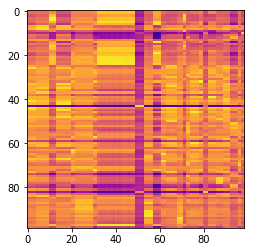

In [22]:
# Plot similarity matrix.
plt.imshow(similarity.similarity_matrix, cmap='plasma')

This matrix shows that there could be more than one closely similar generated sample, for each original sample. How does that look in practice?

In [23]:
print(similarity.corresponding_samples)

[45 45 71 11 11 42 59  5  6 71 97 16 95 13 57 11 71 38 48 57 46 47 37 42
 42 66  1 79 30 73 67 90 78 13 64 18 89  4 90 84 89  1 19 49  0 17 76 19
 16 88 63 94 72 95 73 72 28 30 91 94 77  7 27 20 20 61 53 14 62 72 96 26
 31 65 93 72 88 87 86 92 92 87 81 91  9 40 24 54 29 22 22 55 55 55 68 68
 68 43 16]


As it is possible to see there is some repertion. Again this may be a consequence that some samples are more similar among eachother, than in comparison between new and generated.
Finally, let us plot comparison of the original sample and its corresonding sample as determined by cosine similarity measure.

In [24]:
plt.rcParams['figure.figsize'] = 10, 10

Plotting comparison: 0
Plotting comparison: 1
Plotting comparison: 2
Plotting comparison: 3
Plotting comparison: 4
Plotting comparison: 5
Plotting comparison: 6
Plotting comparison: 7
Plotting comparison: 8
Plotting comparison: 9
Plotting comparison: 10
Plotting comparison: 11
Plotting comparison: 12
Plotting comparison: 13
Plotting comparison: 14
Plotting comparison: 15
Plotting comparison: 16
Plotting comparison: 17
Plotting comparison: 18
Plotting comparison: 19
Plotting comparison: 20
Plotting comparison: 21
Plotting comparison: 22
Plotting comparison: 23
Plotting comparison: 24
Plotting comparison: 25
Plotting comparison: 26
Plotting comparison: 27
Plotting comparison: 28
Plotting comparison: 29
Plotting comparison: 30
Plotting comparison: 31
Plotting comparison: 32
Plotting comparison: 33
Plotting comparison: 34
Plotting comparison: 35
Plotting comparison: 36
Plotting comparison: 37
Plotting comparison: 38
Plotting comparison: 39
Plotting comparison: 40
Plotting comparison: 41
Pl

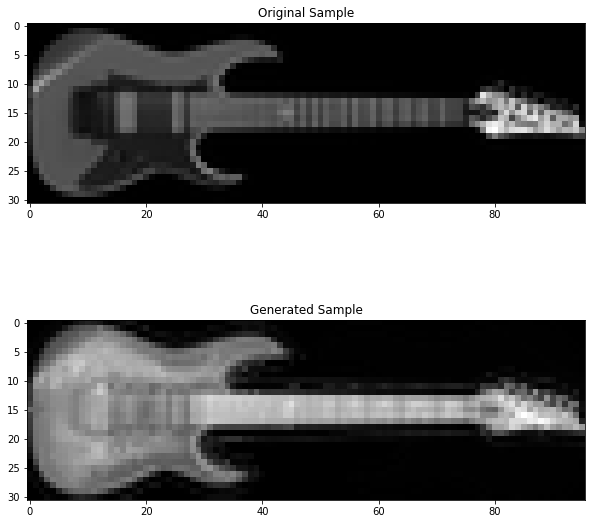

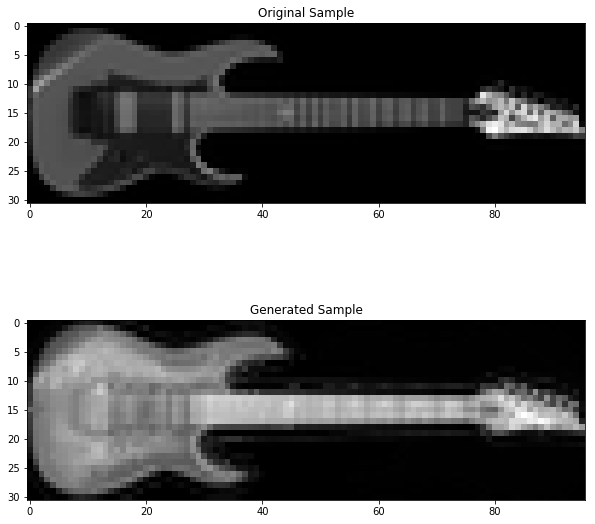

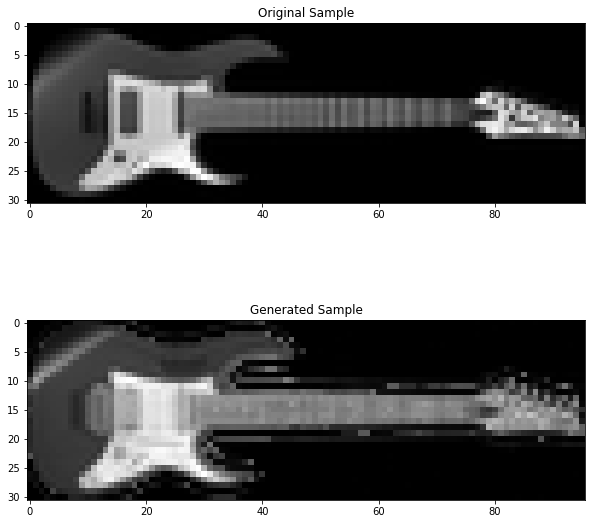

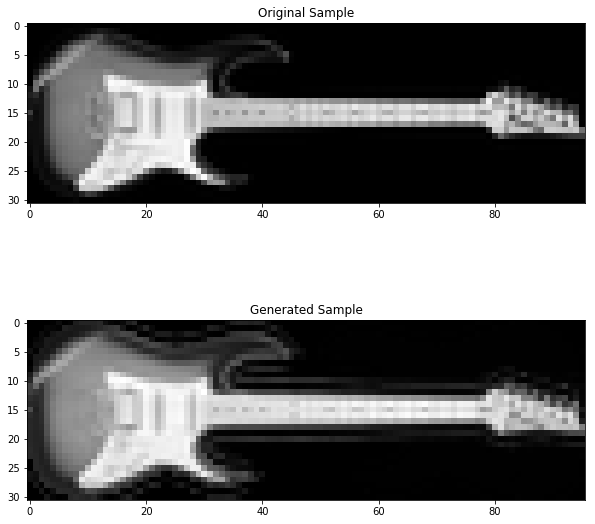

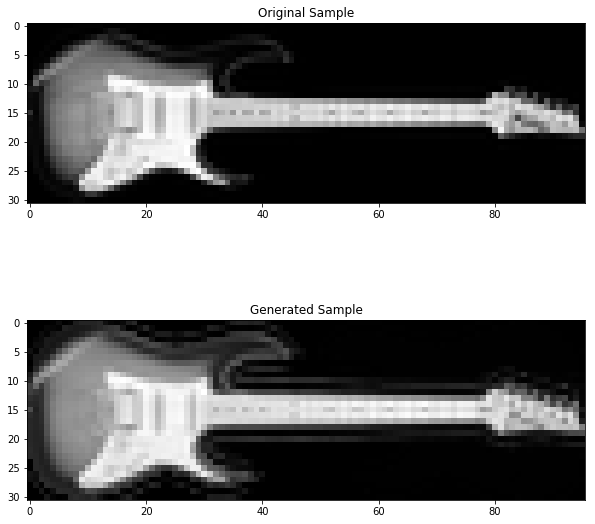

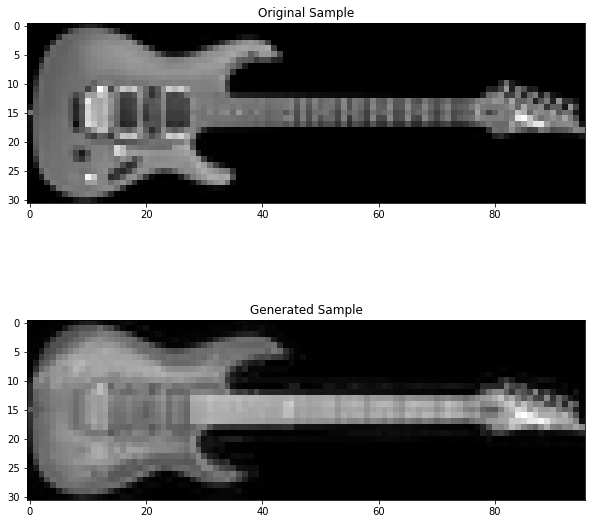

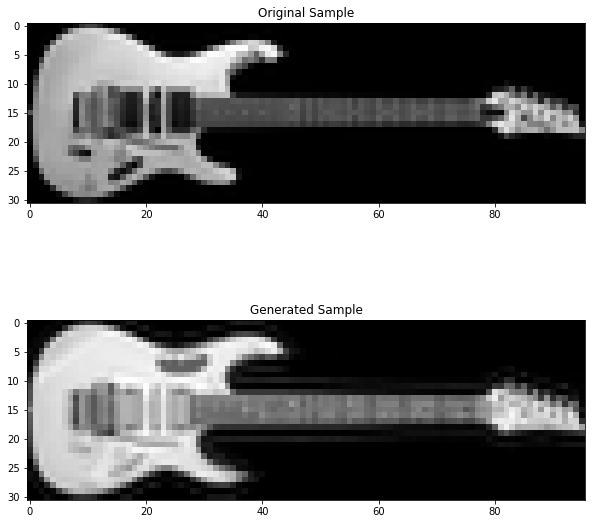

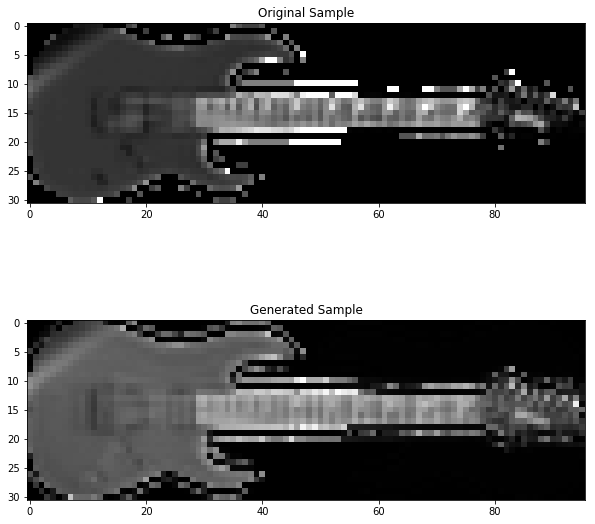

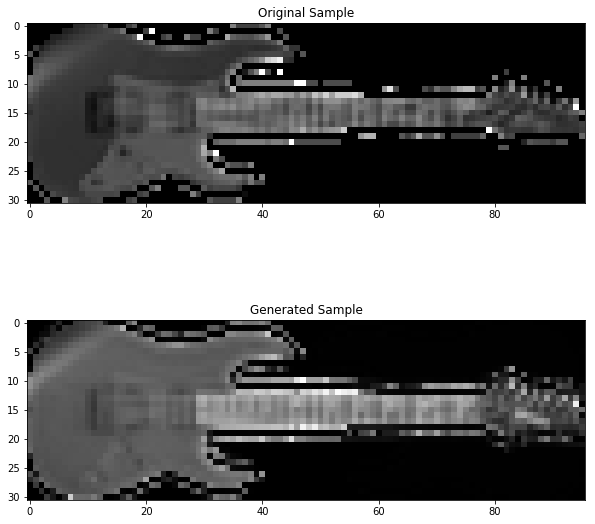

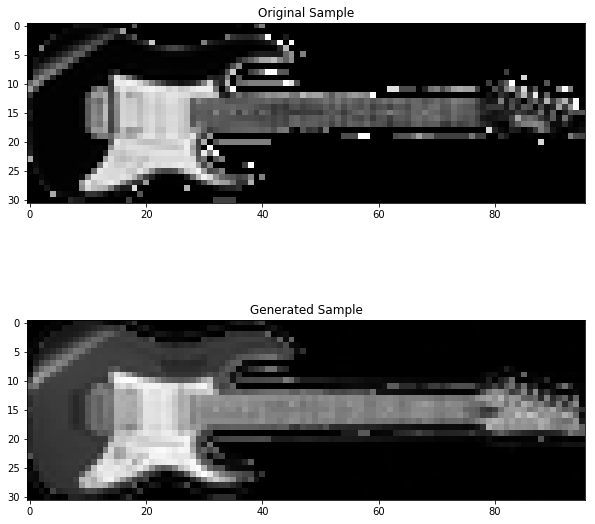

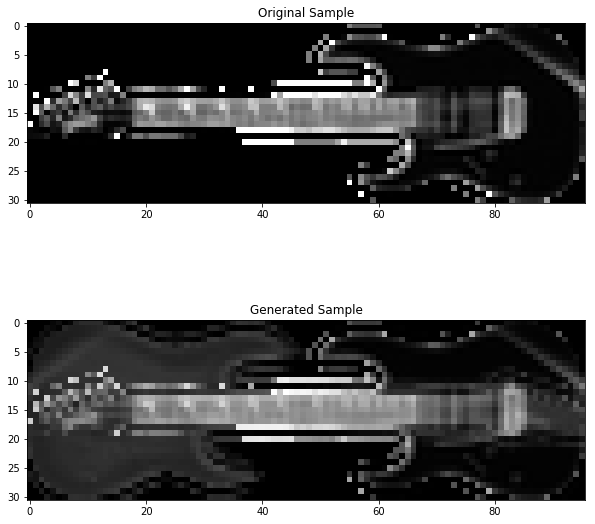

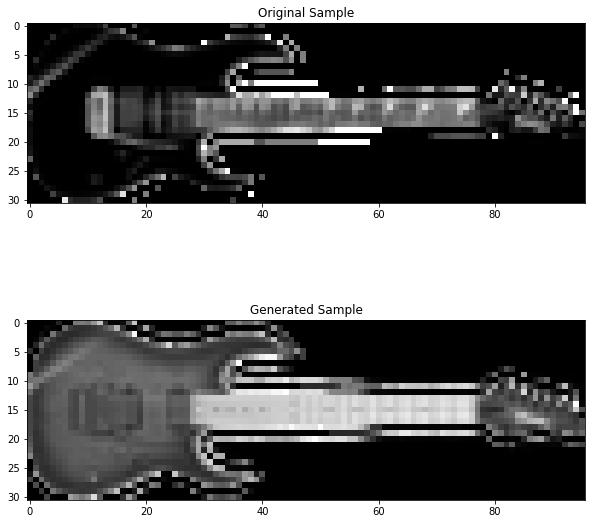

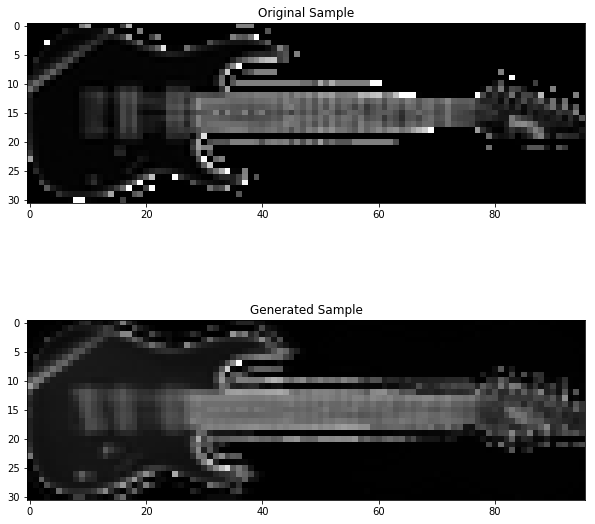

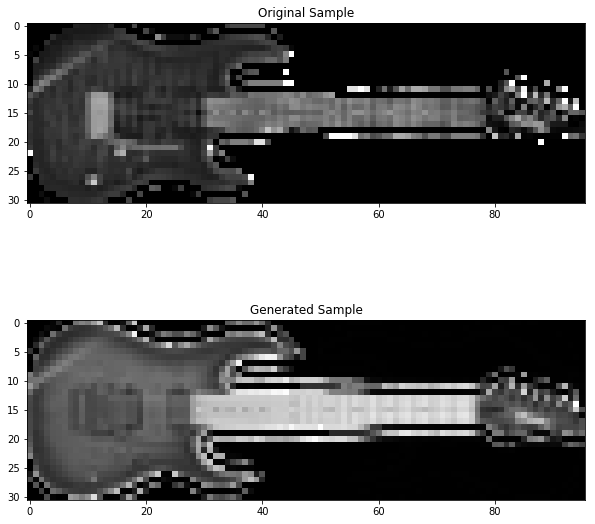

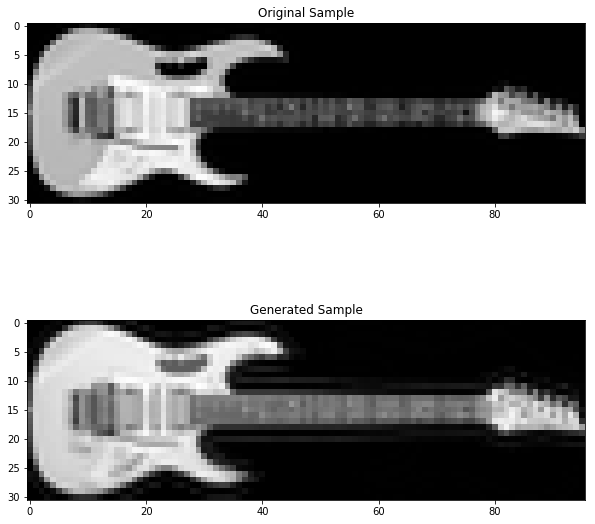

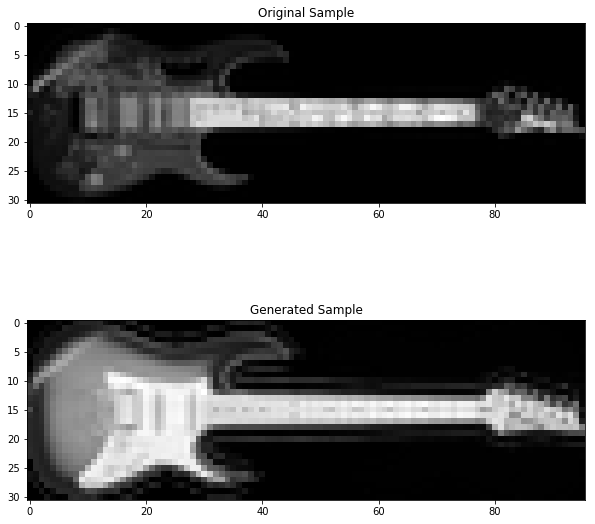

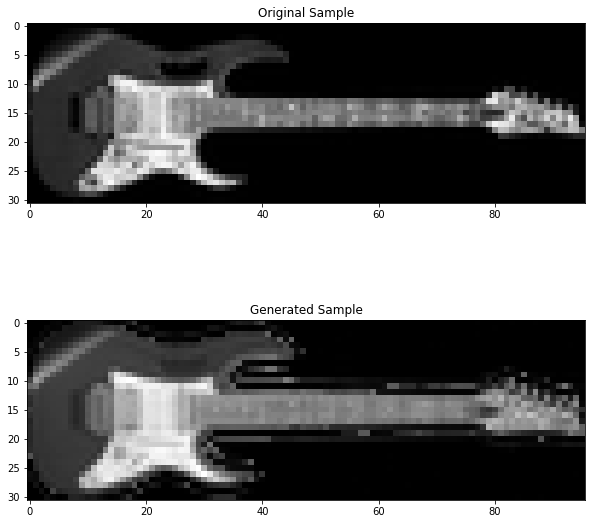

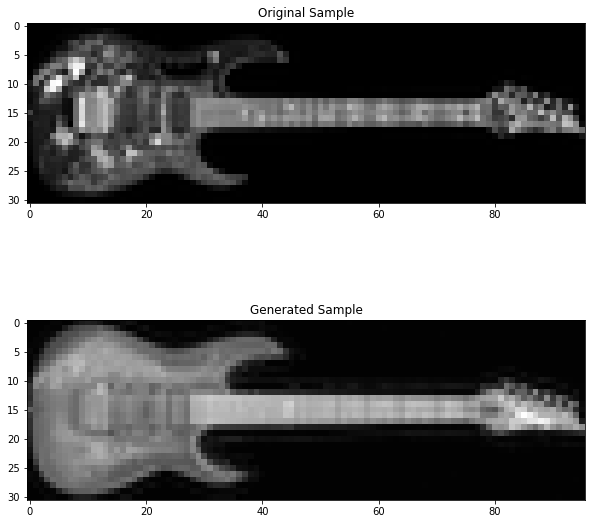

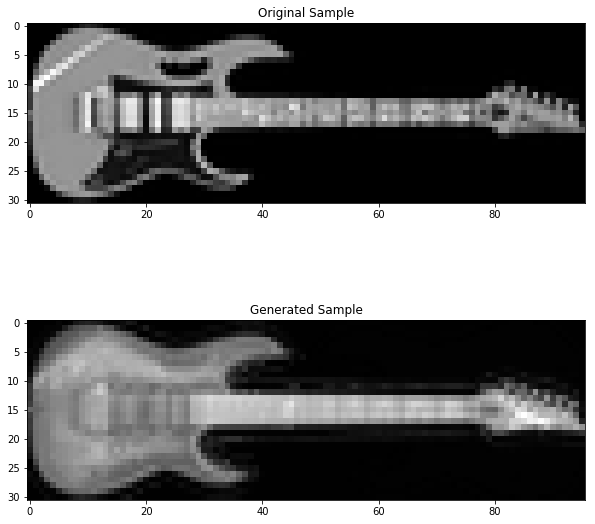

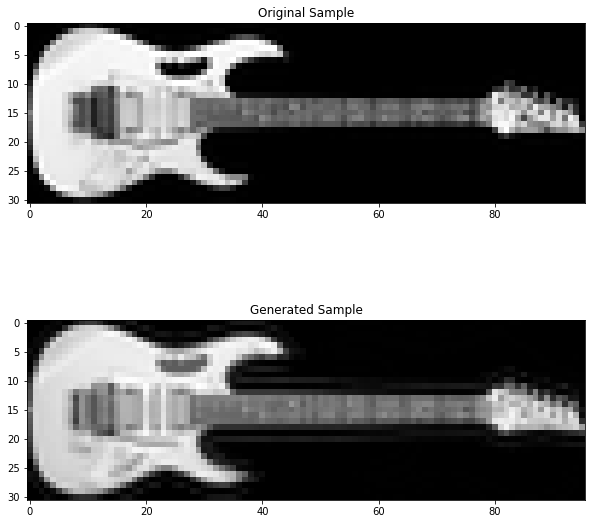

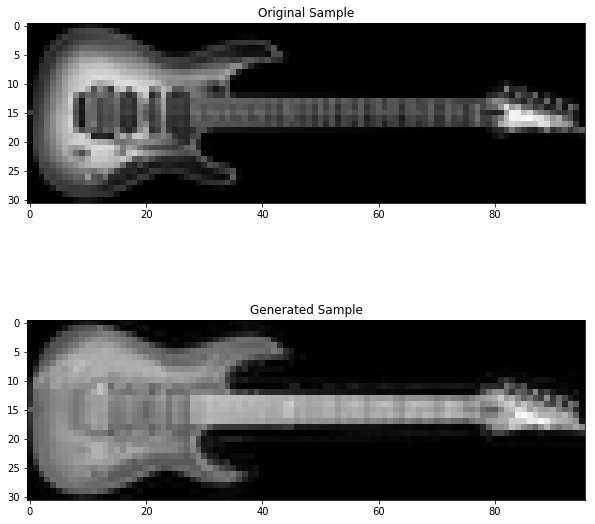

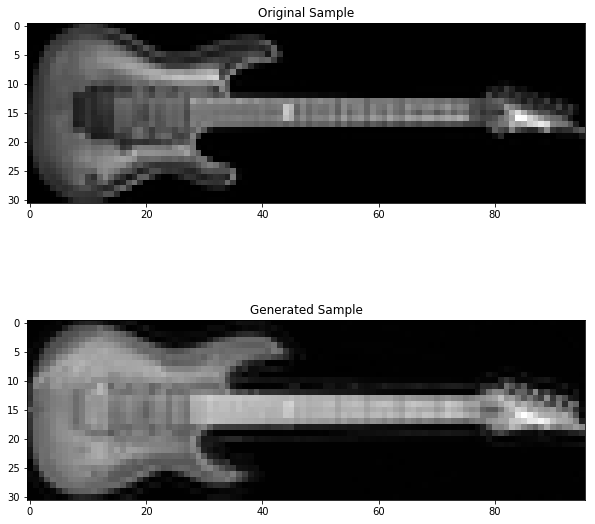

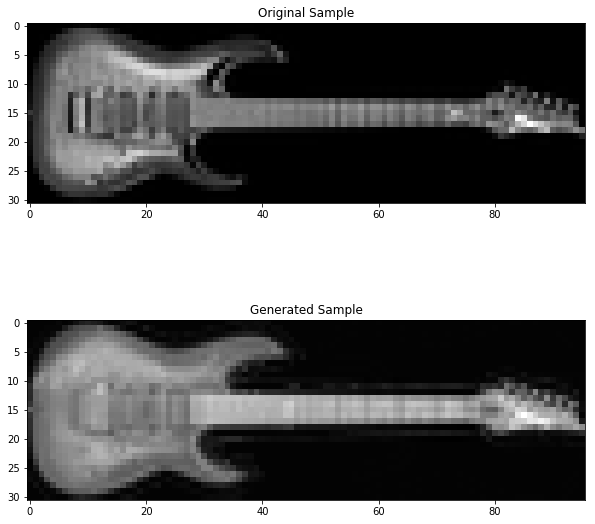

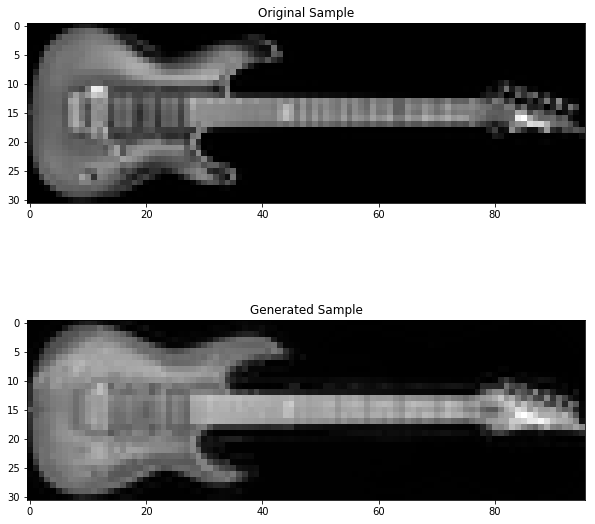

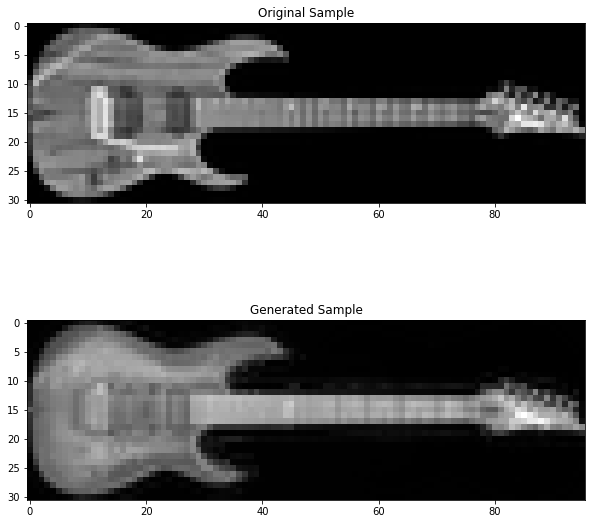

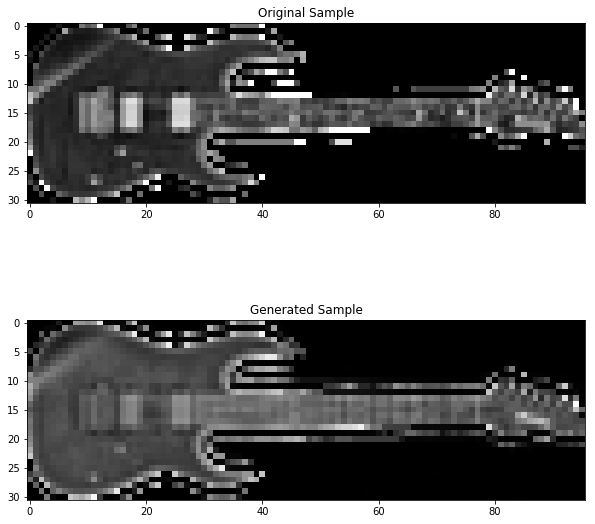

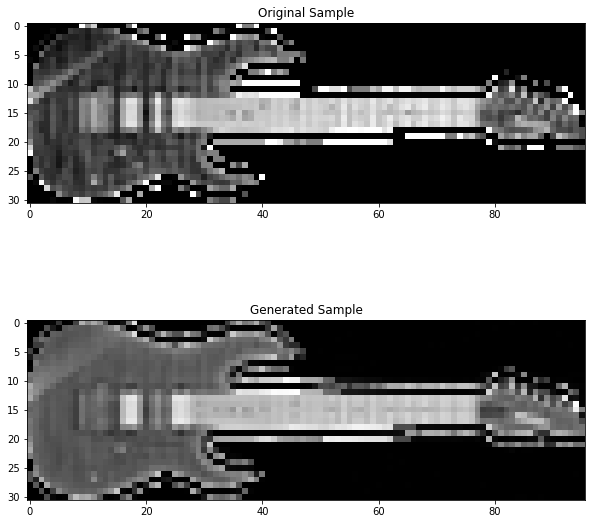

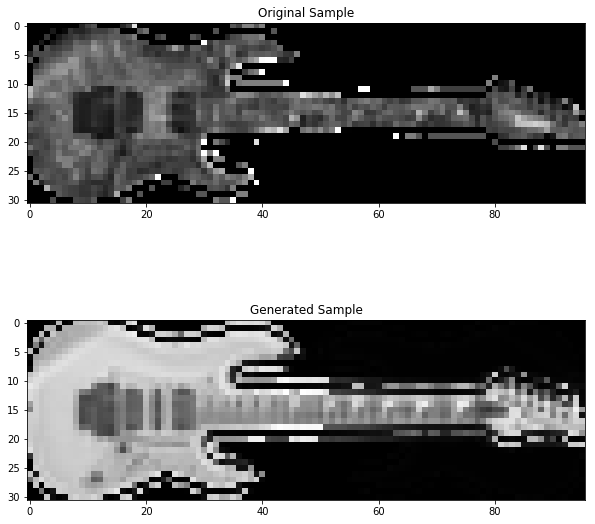

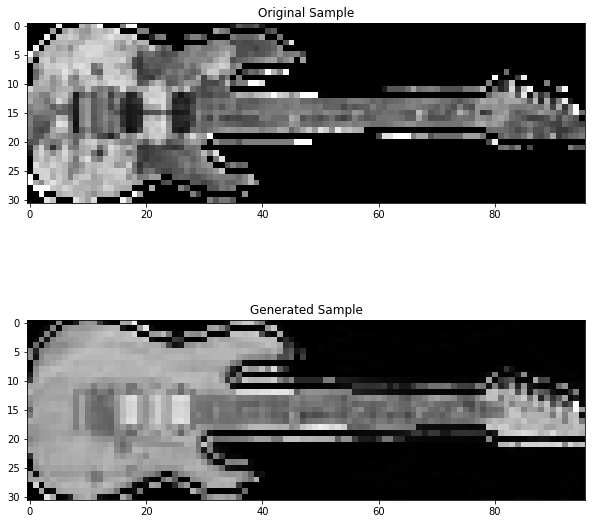

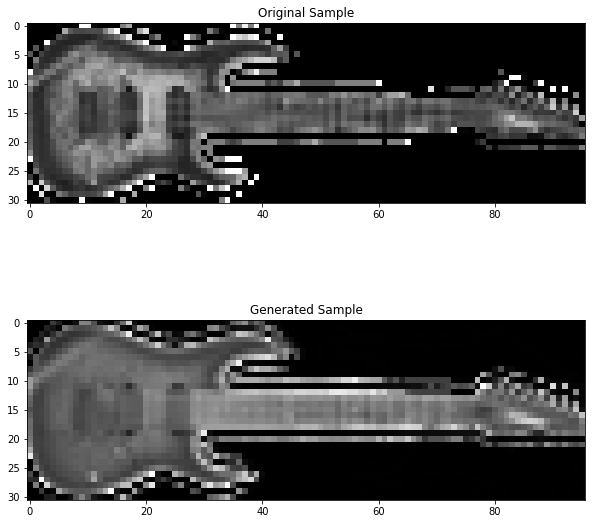

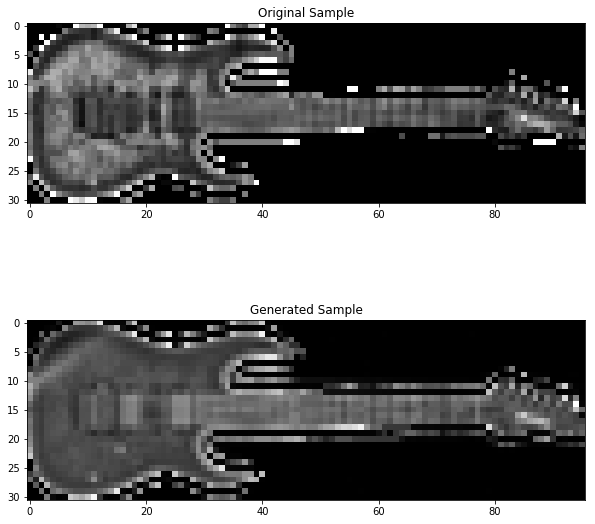

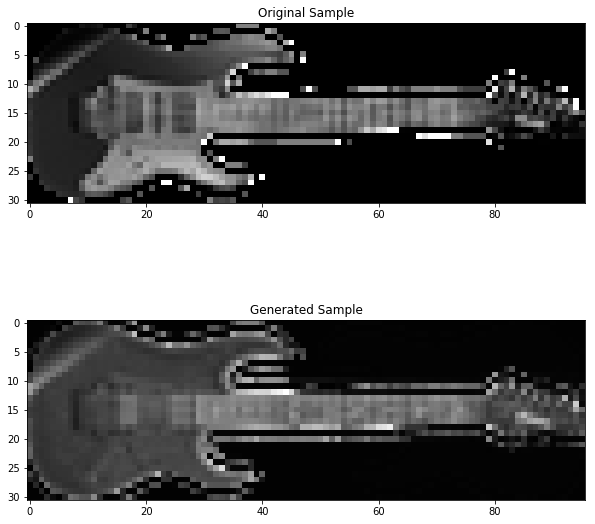

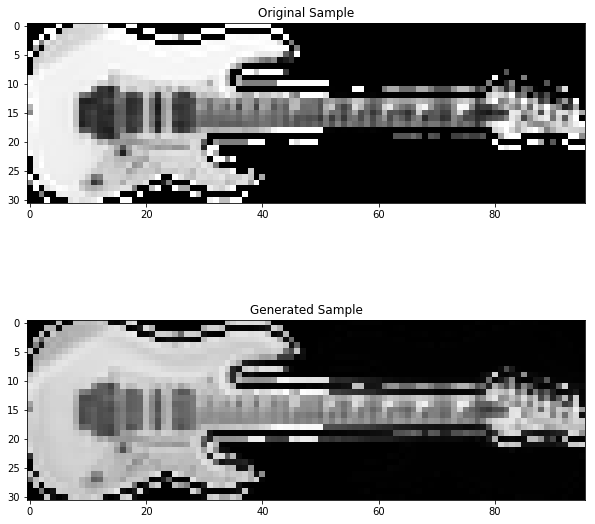

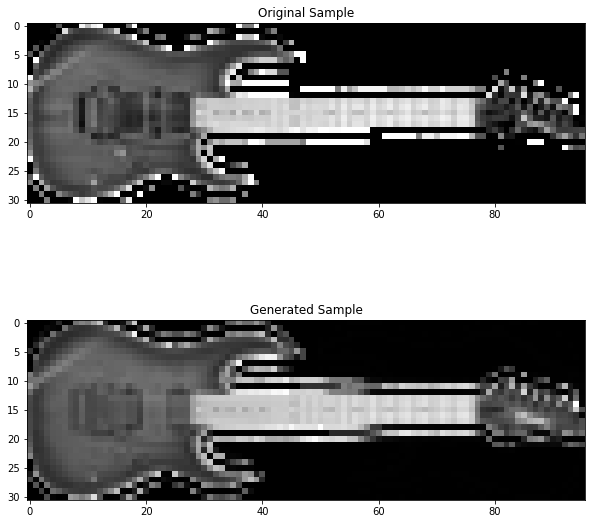

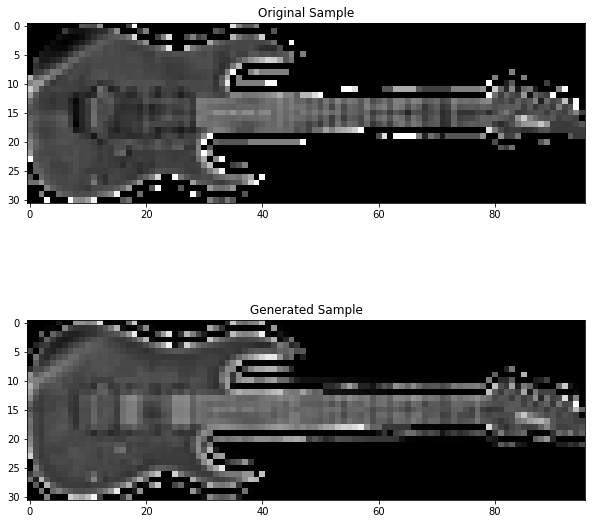

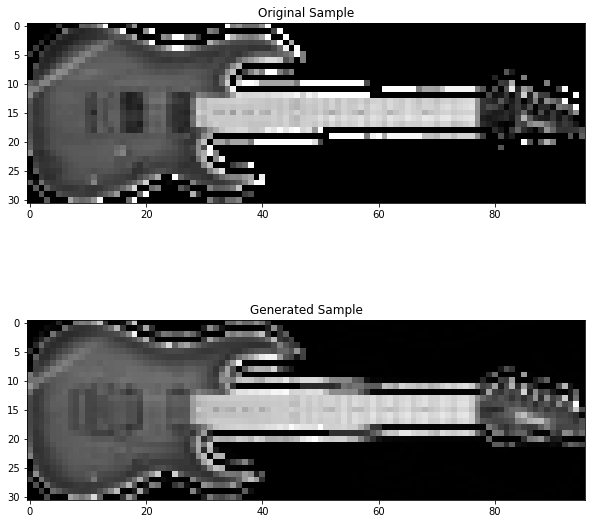

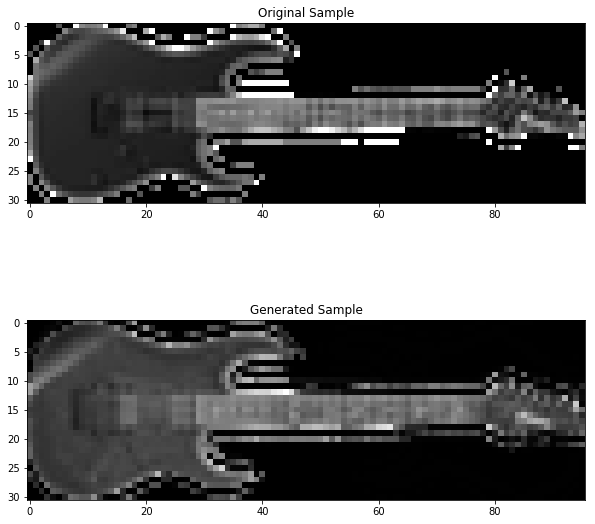

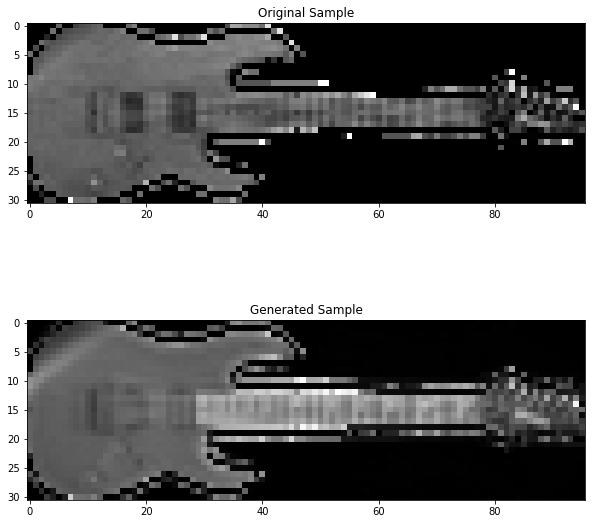

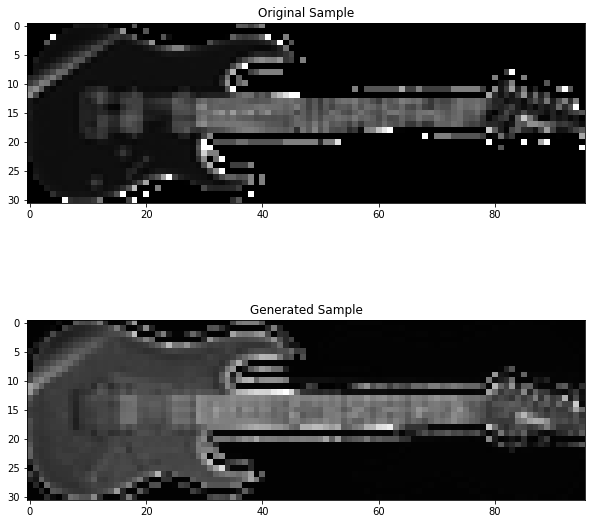

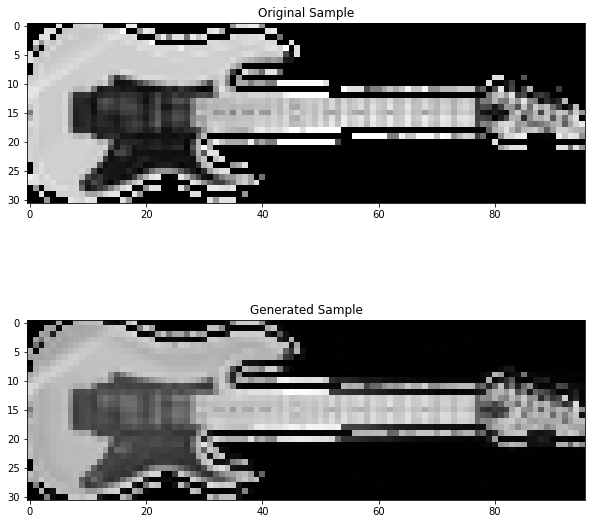

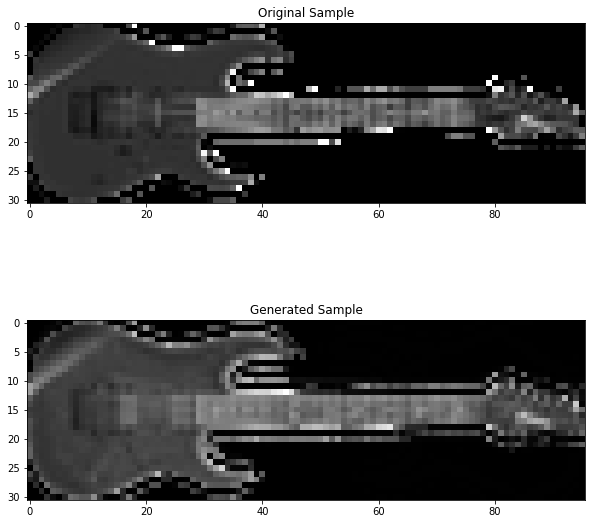

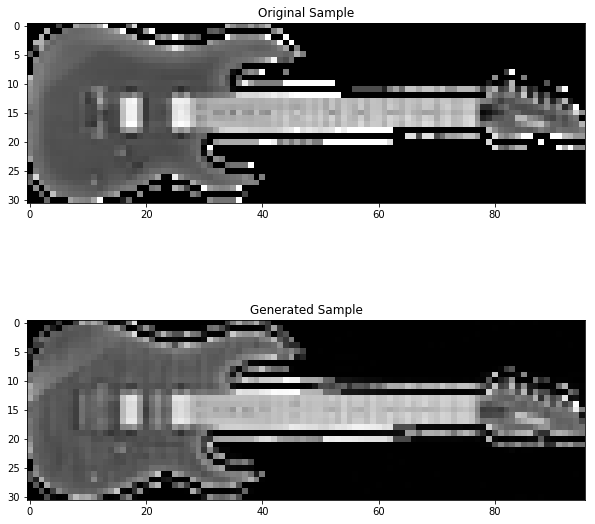

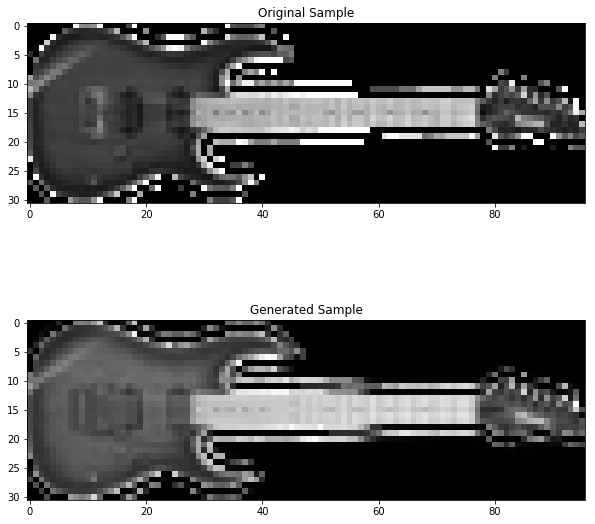

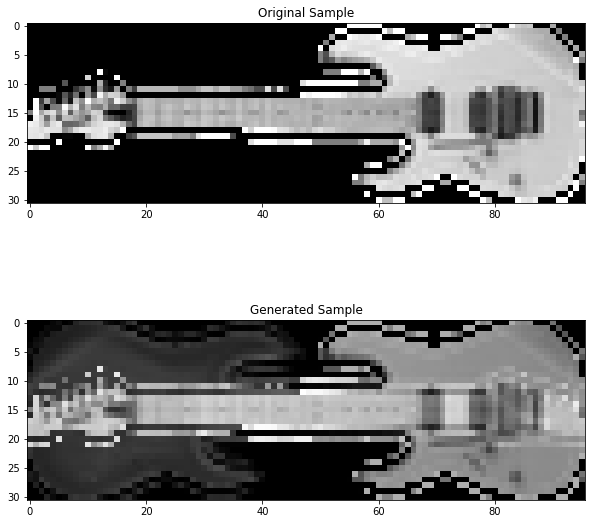

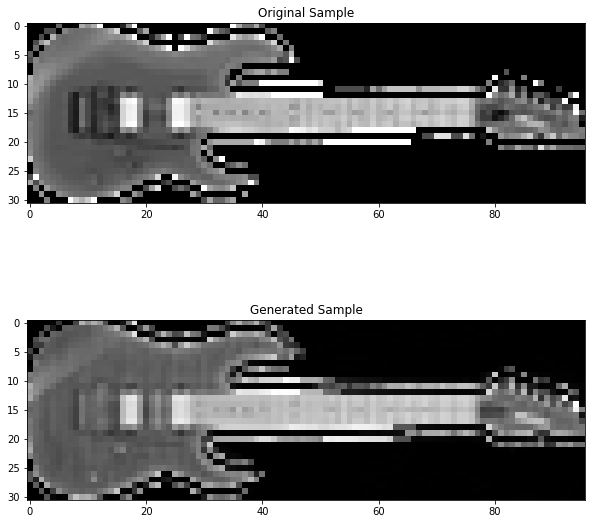

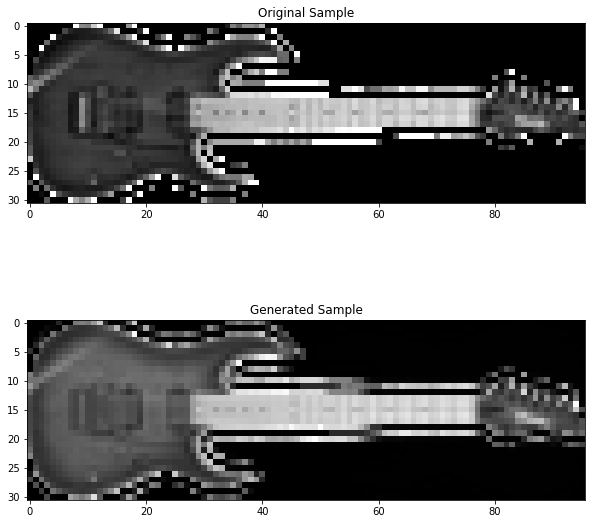

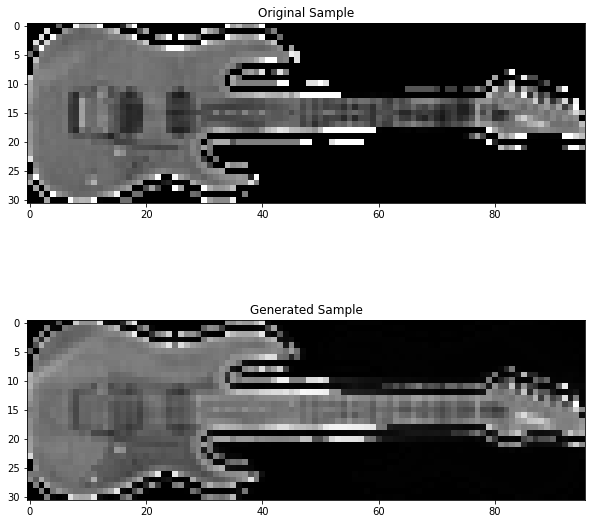

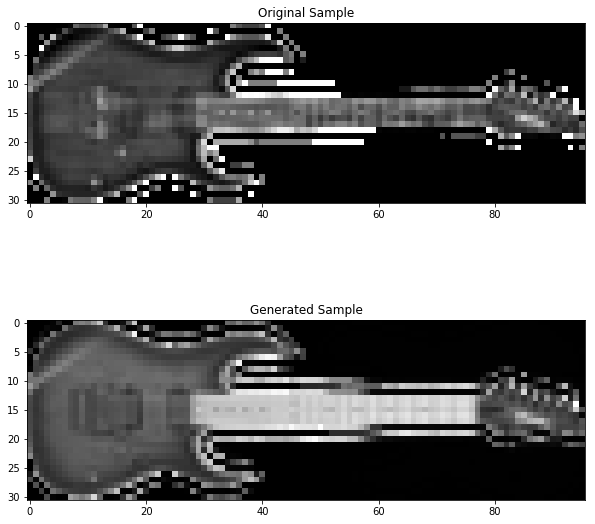

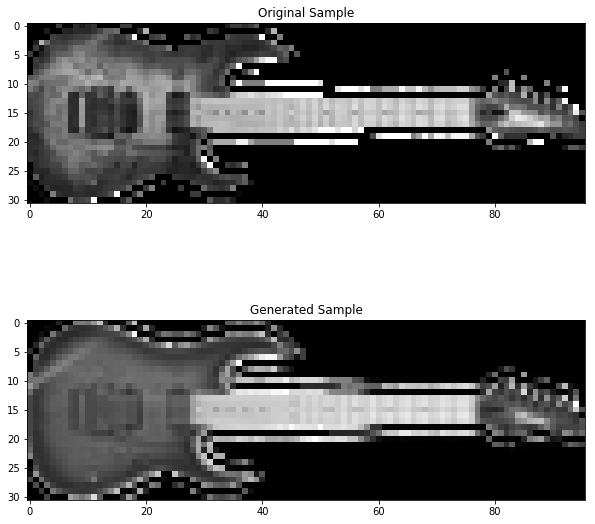

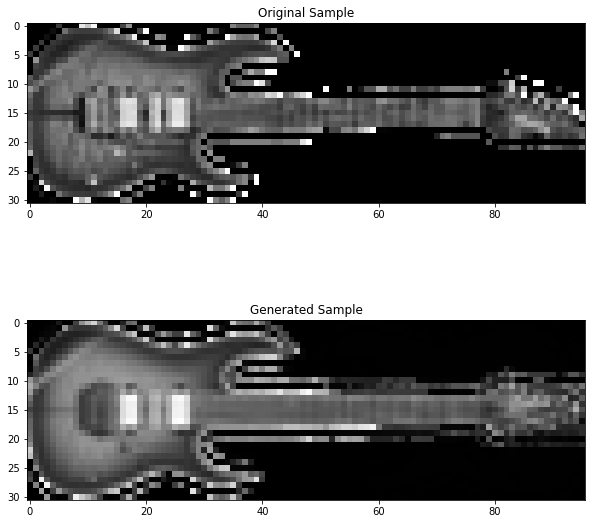

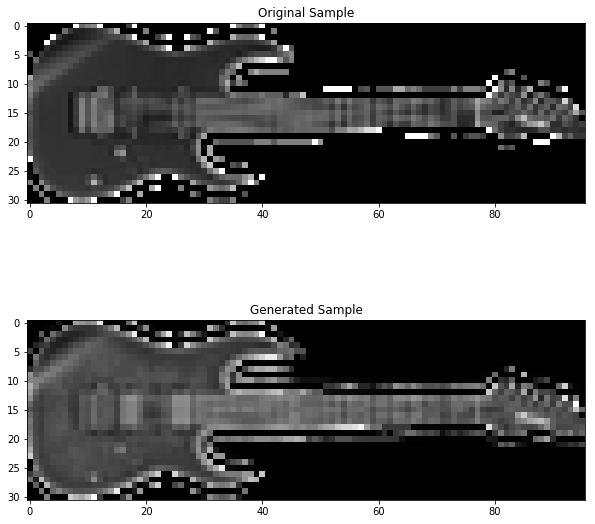

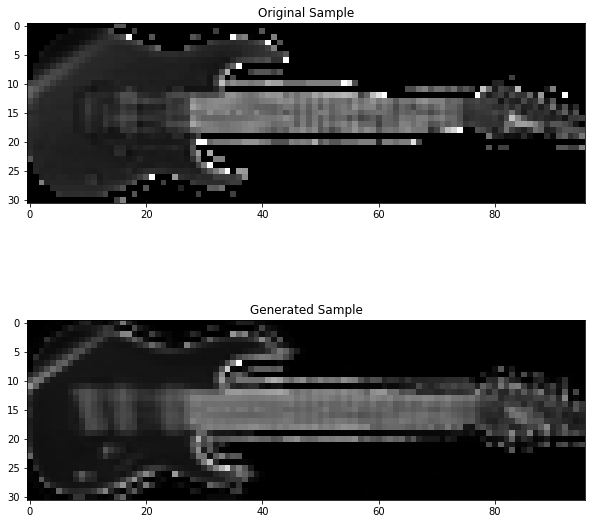

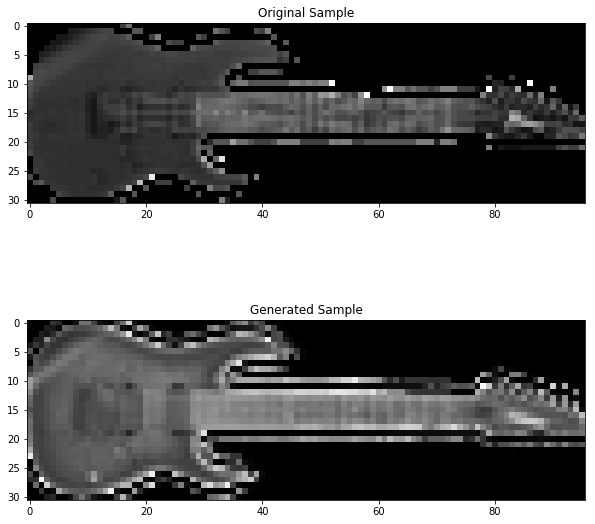

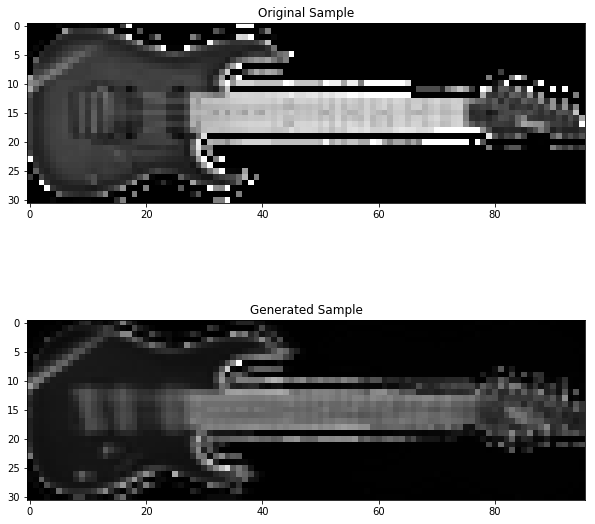

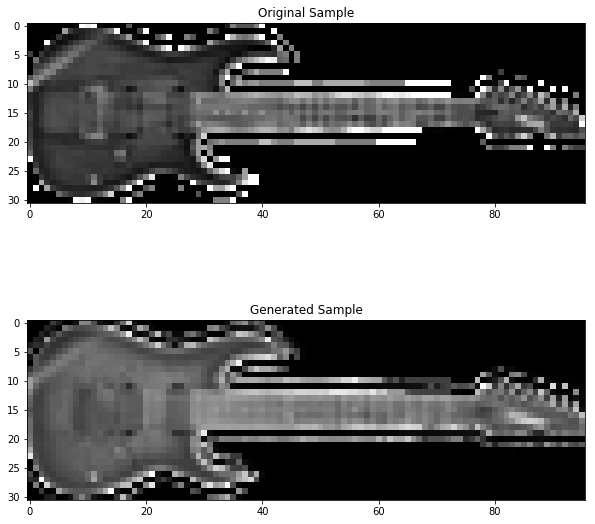

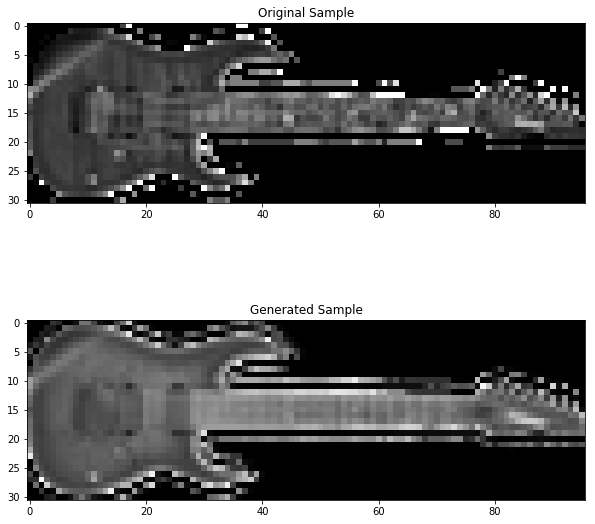

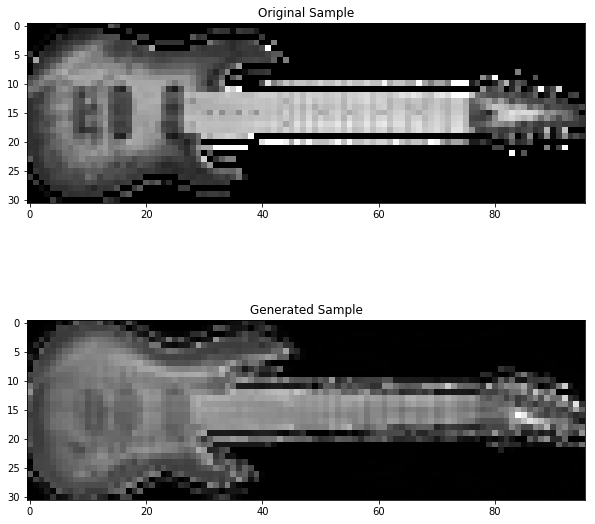

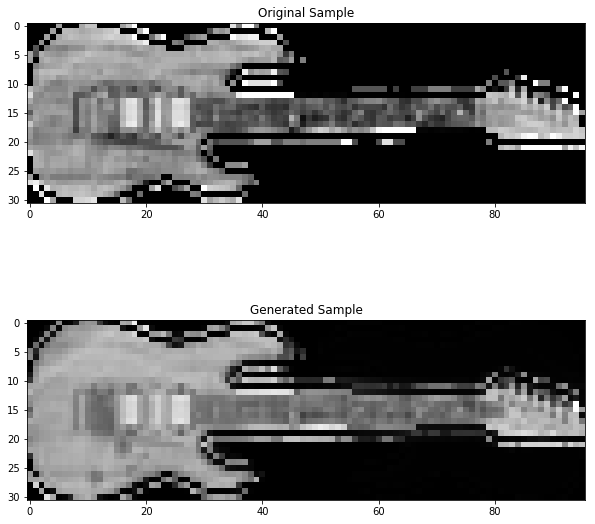

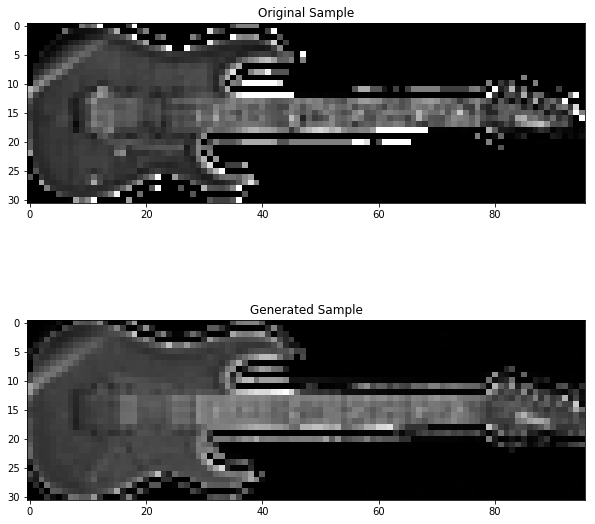

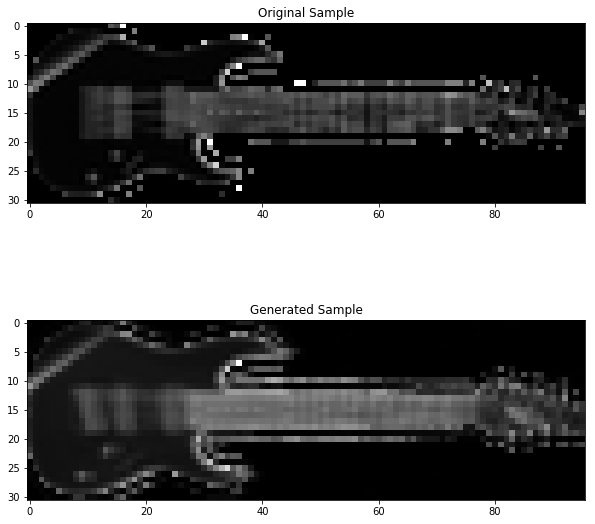

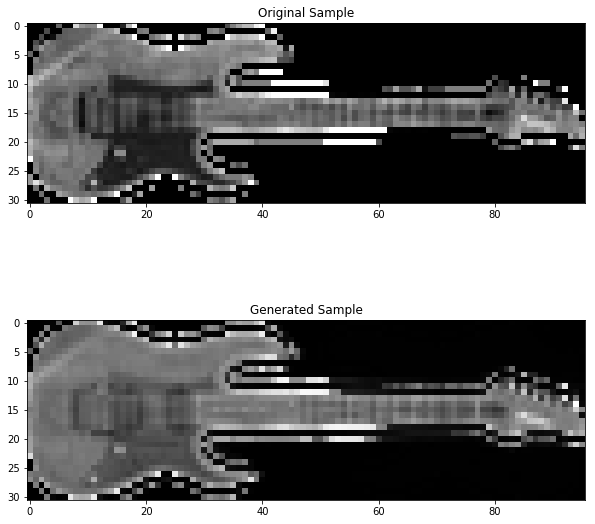

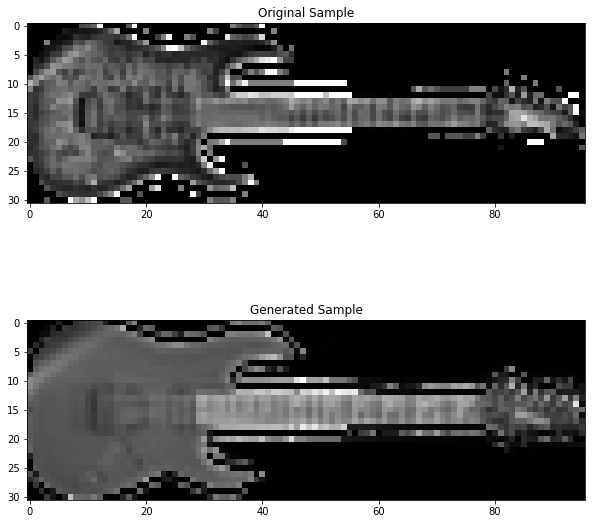

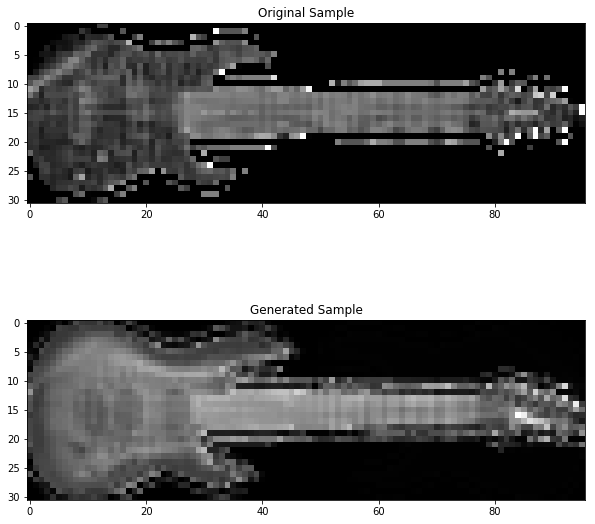

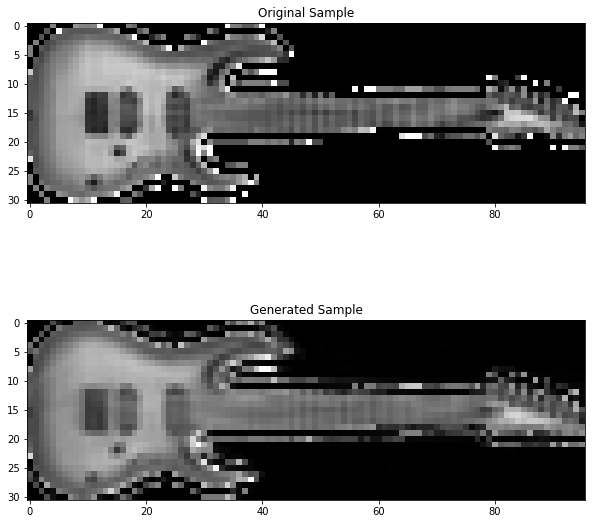

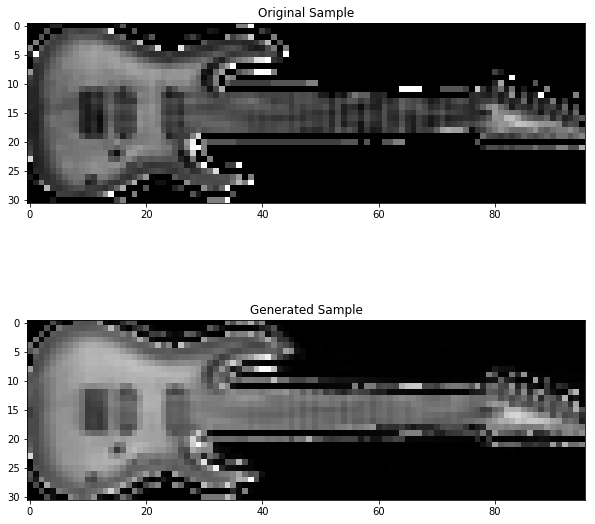

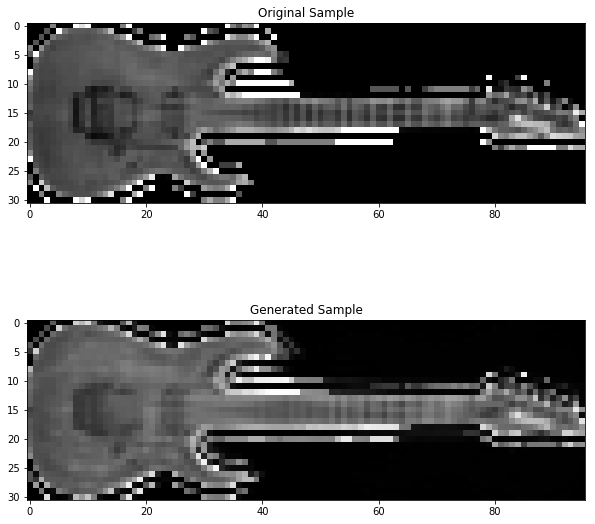

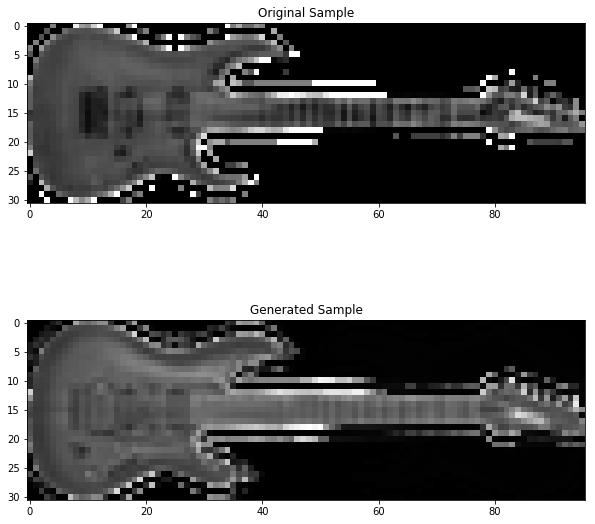

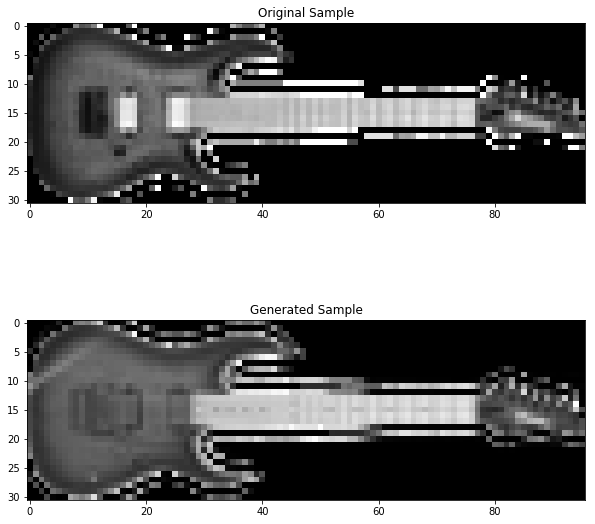

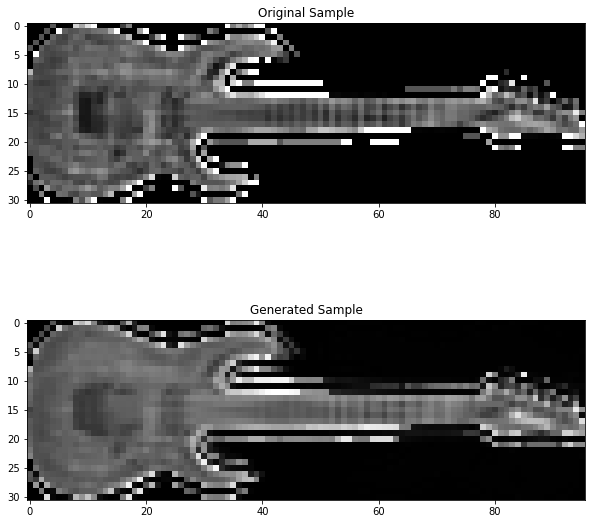

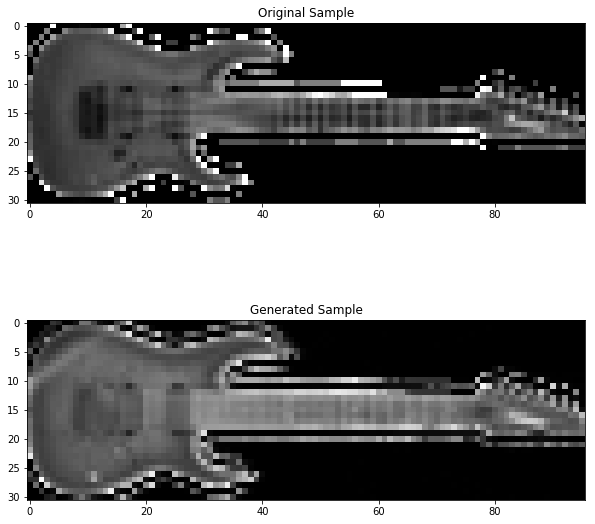

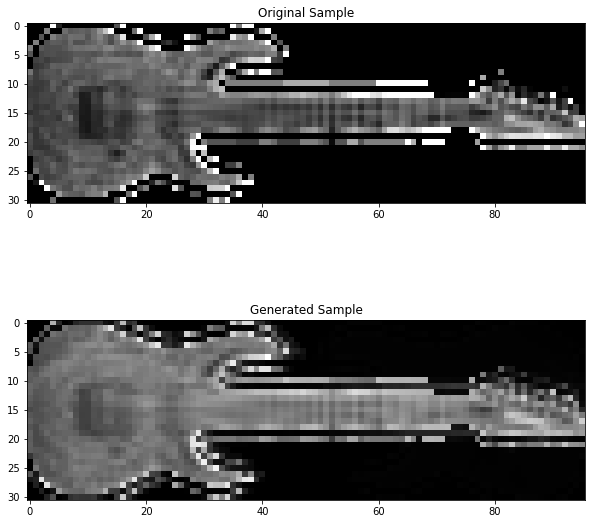

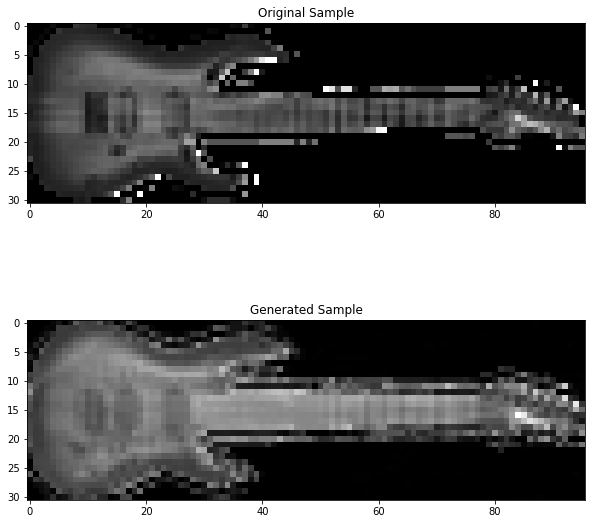

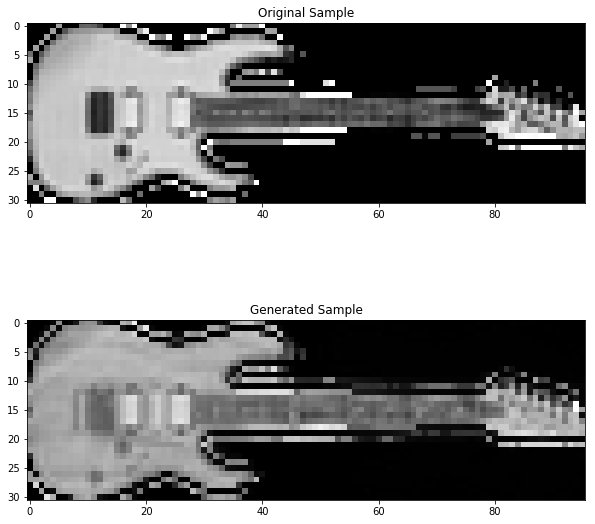

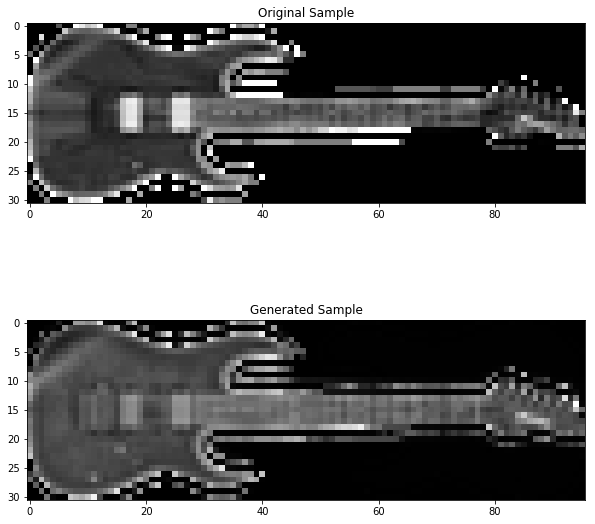

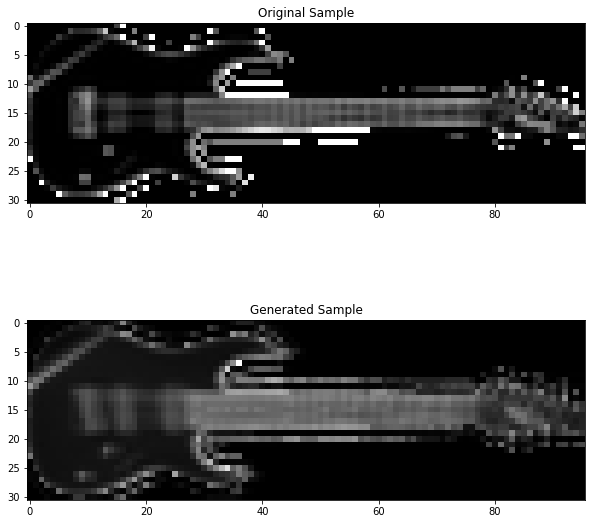

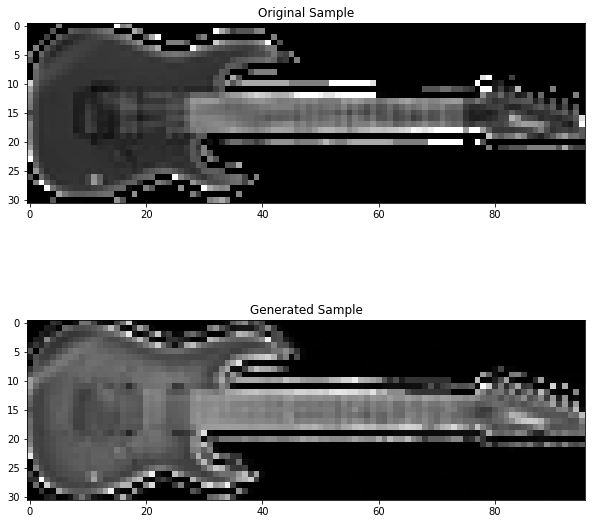

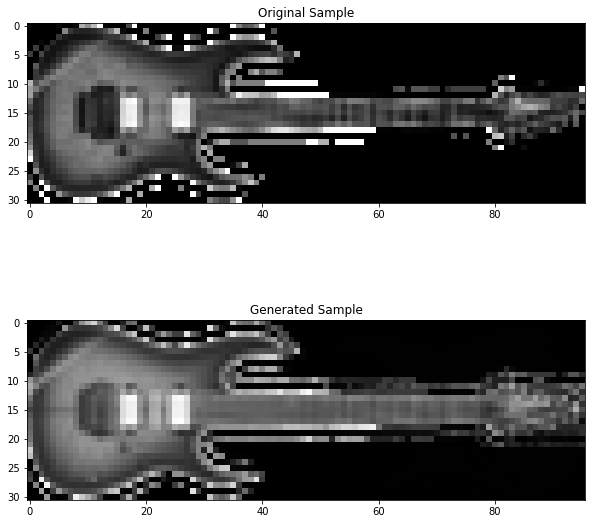

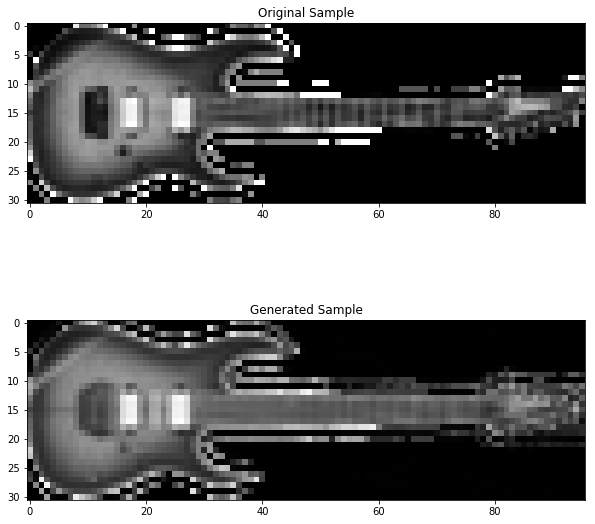

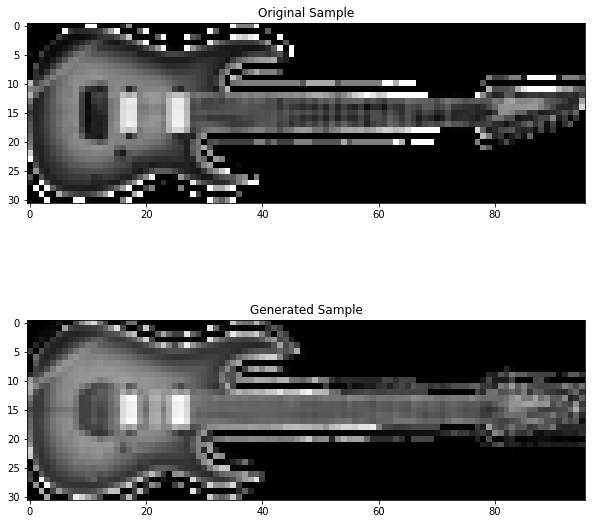

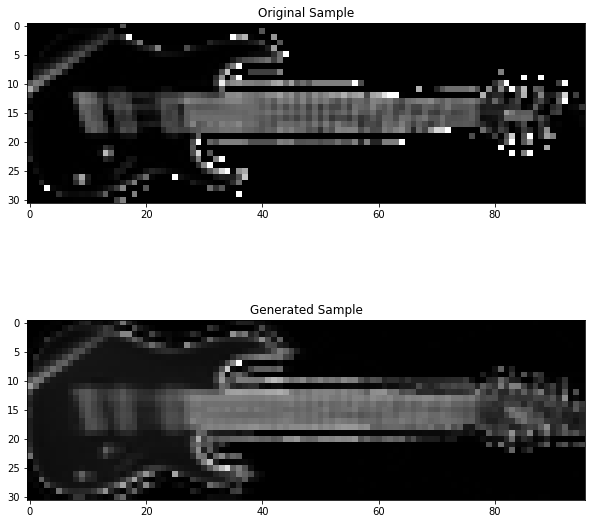

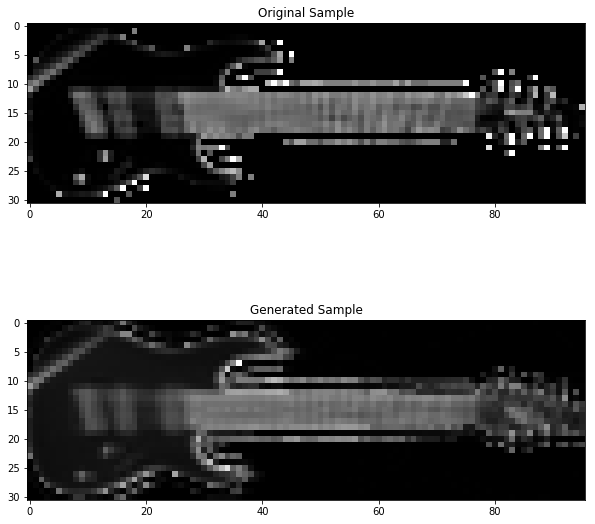

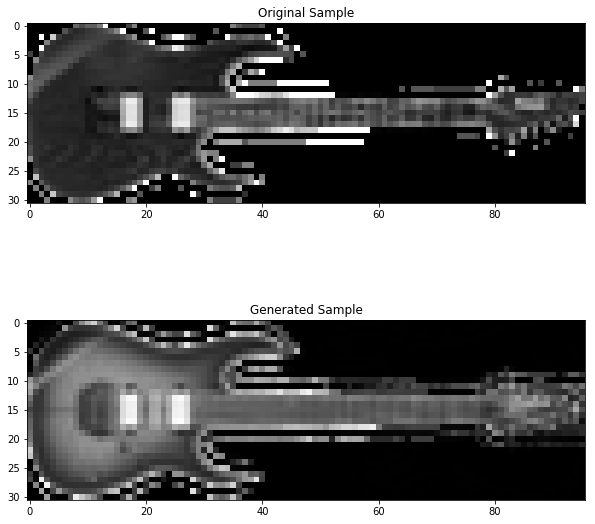

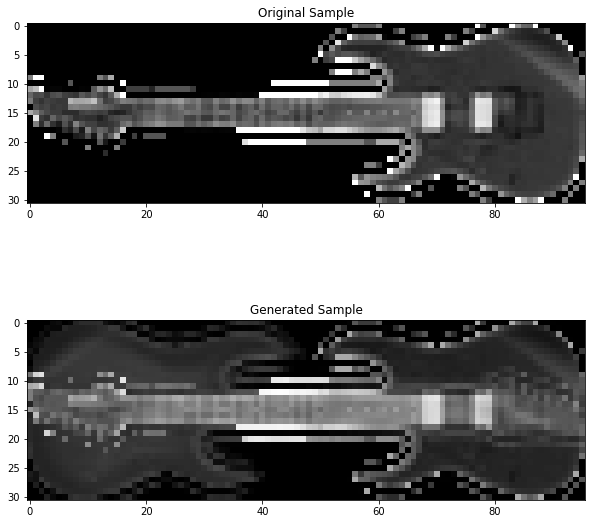

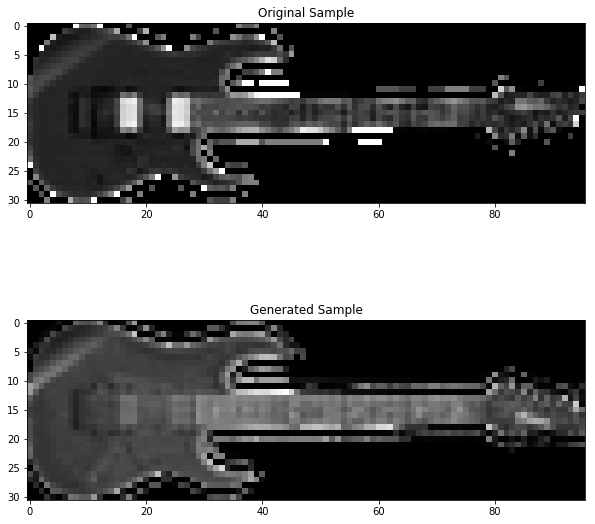

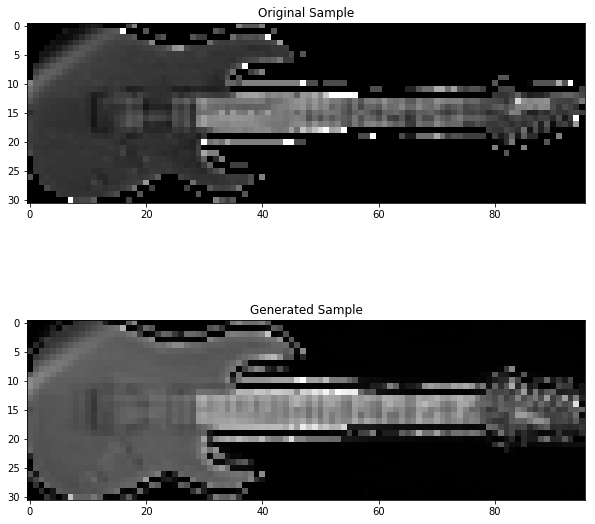

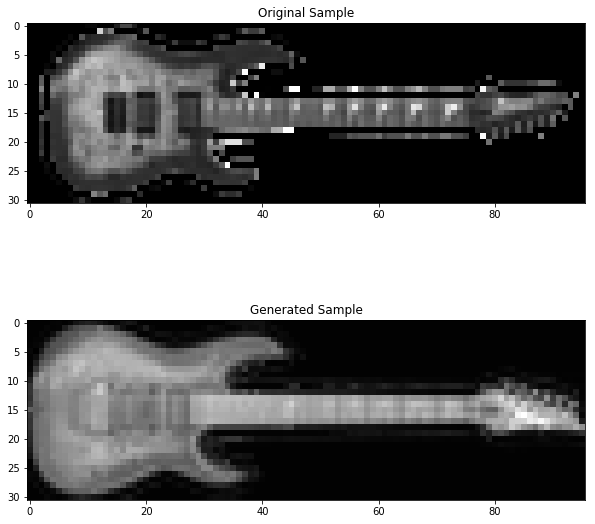

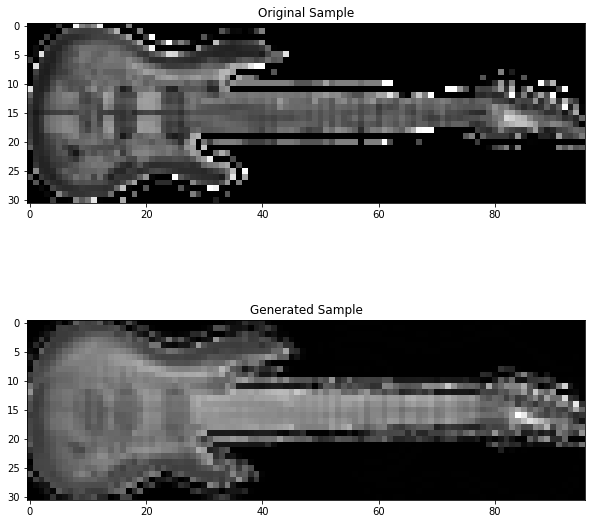

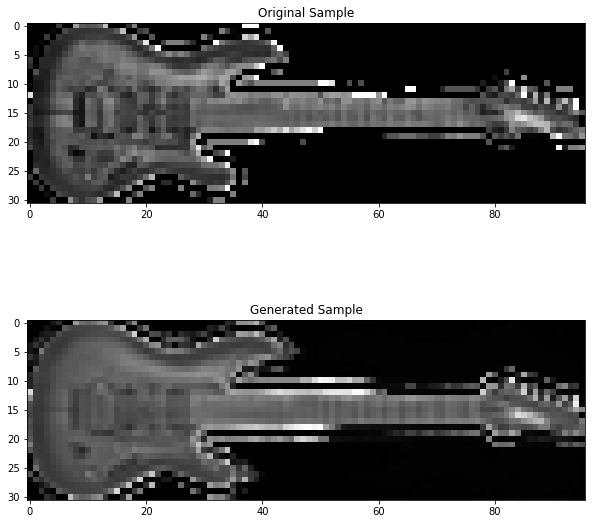

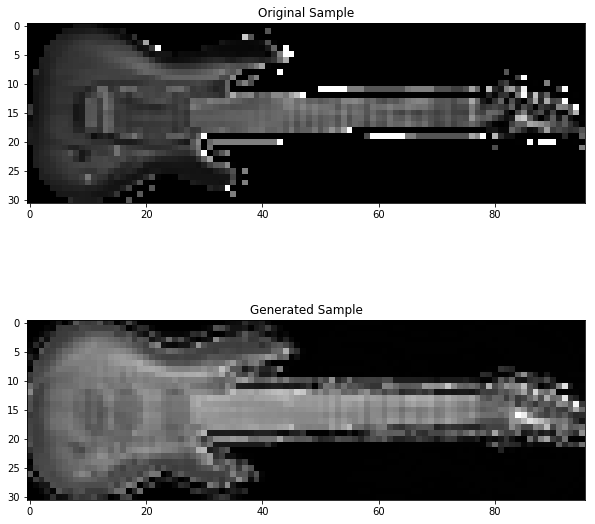

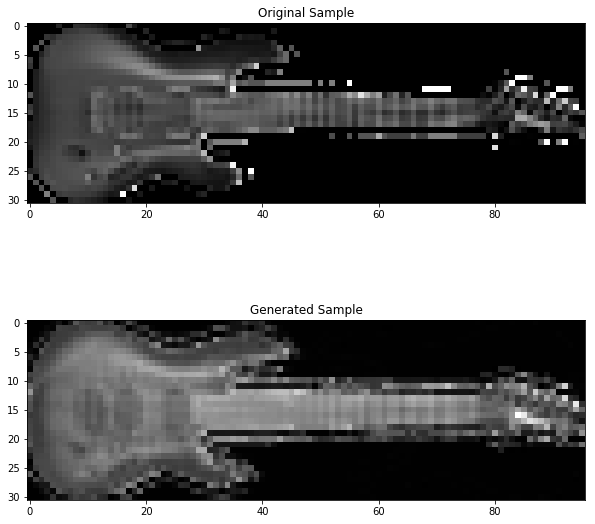

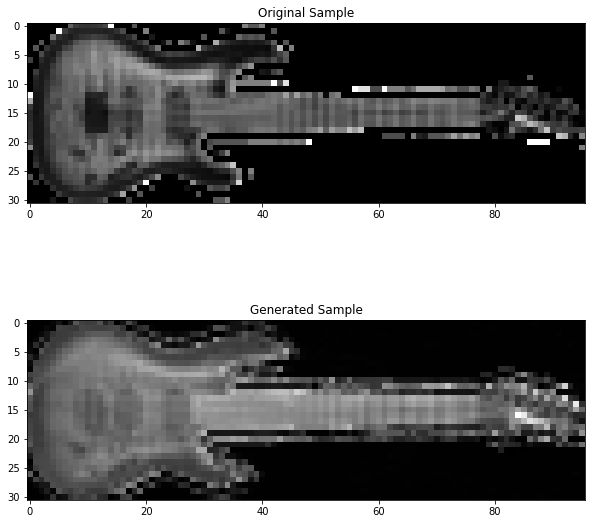

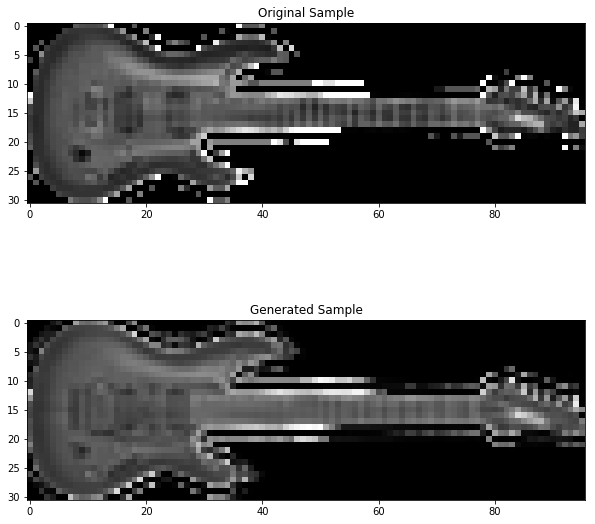

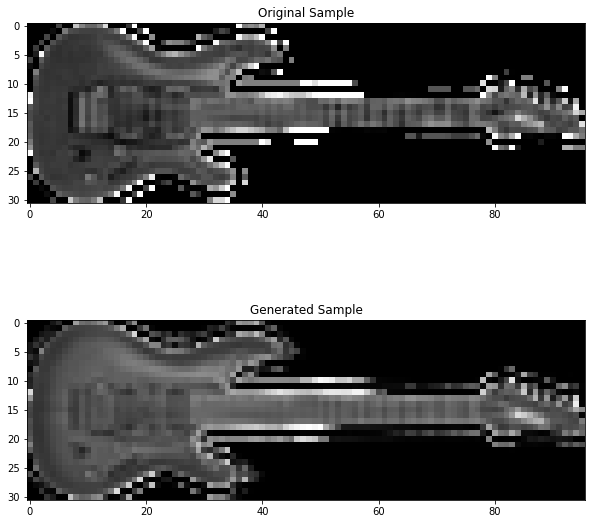

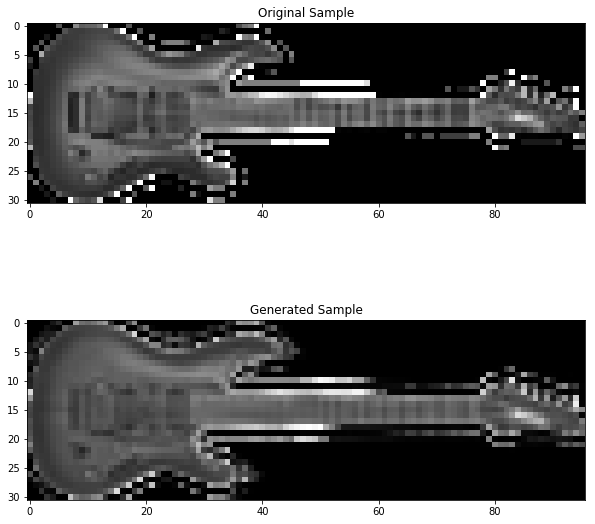

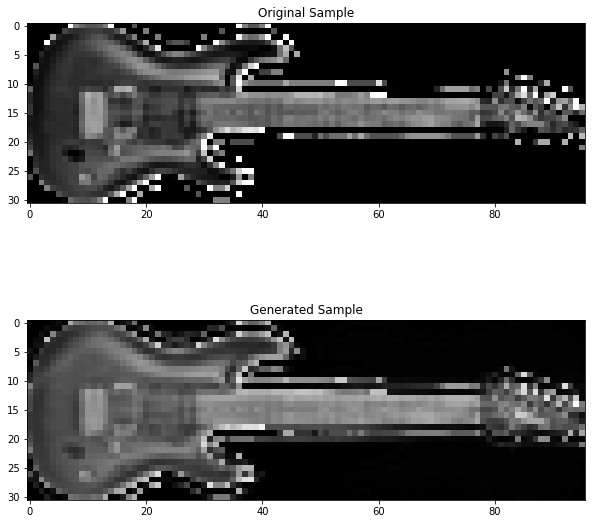

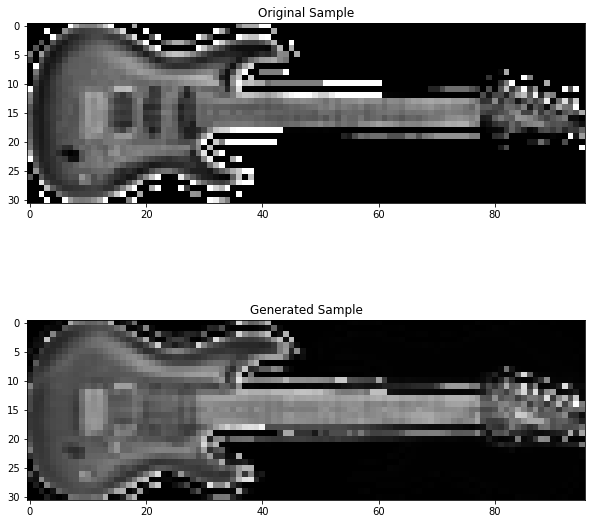

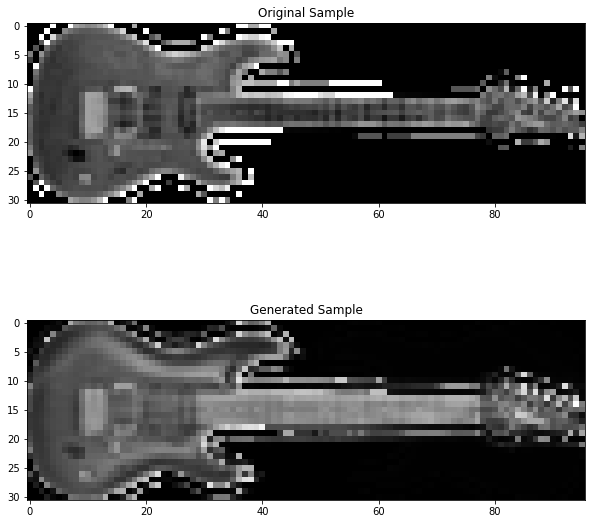

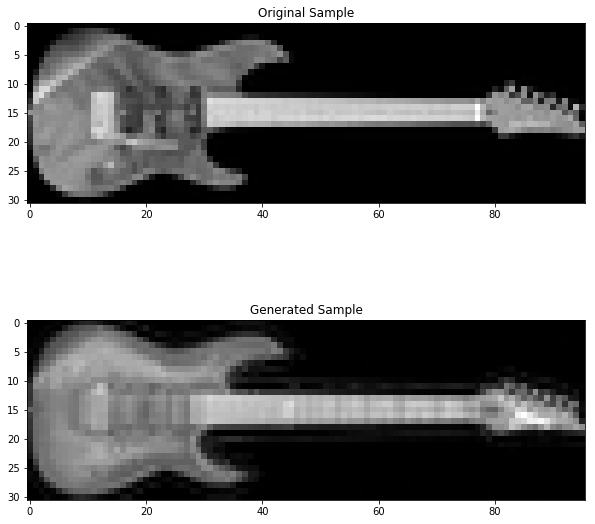

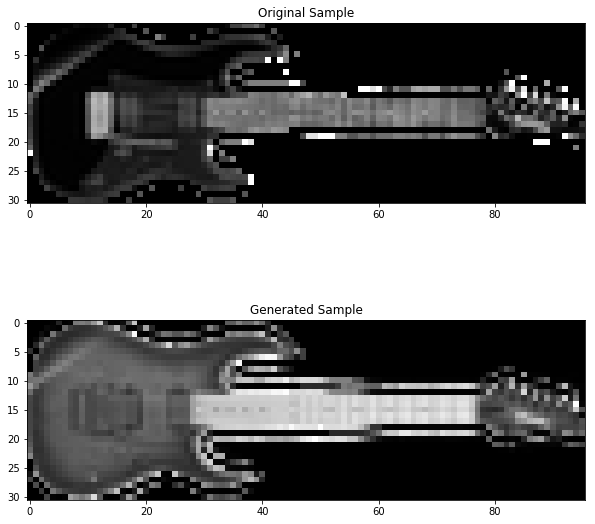

In [35]:
# Plot original and most similar samples.
plot_comparison_of_original_and_generated_samples(
    original_samples=raw_data,
    generated_samples=generated_data,
    similarity_list=similarity.corresponding_samples
)

# Conclusion

As we can see the generative probabilistic version of Gaussian Mixture Model has proven to be a suitable choice for this learning task. The ability of the model to learn underlaying distribution which has generated the data, is confirmed through visual inspection of generated samples.
Implications of this modeling proces are wide. Let us review just a few.
- Generated data can be used for data augmentation in cases when the amount of original data is limited. This can be a huge advatage for the model training process because, which otherwise could not be initiated at all.
- If there is an assumption that the input data will degrade over time, mixing generated and original data can produce more robust models with greater potential to maintain its performance after confronted with degradation of quality of input data.
However, it is also important to maintain control over training process, examine the generated samples, and ensure that can serve their purposes.

Just like with any other ML solution, care and attention is needed in order to bring the training process to satisfatory outcome.